In [ ]:
#!/usr/bin/env python3
# %matplotlib widget
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl
import scipy.stats as stats

import pygama
from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
from pygama.dsp.WaveformBrowser import WaveformBrowser
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
bkg_sub = True

dg = DataGroup('$CAGE_SW/processing/cage.json', load=True)
run = 64 #66
# cycle = 1481
str_query = f'run=={run} and skip==False'
# str_query = f'cycle=={cycle} and skip==False'
dg.fileDB.query(str_query, inplace=True)
# view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
print(dg.fileDB['runtype'])
# print(dg.fileDB)

dsp_id = '02'
# dsp_id = '02'

867    alp
868    alp
869    alp
870    alp
871    alp
872    alp
873    alp
874    alp
875    alp
876    alp
Name: runtype, dtype: object


In [3]:
# Working with dsp or hit files?

hit = True 
# hit = False #ie working with dsp files

In [4]:
# Working with calibrated or uncalibrated data?

cal = True #calibrated data
# cal = False #uncalibrated data

In [5]:
# Working in your own directory or with the CAGE_lh5 directory?

# user = False # CAGE_lh5 directory
user = True # hit filesin my personal directory

In [6]:
#get runtime, startime, runtype

runtype_list = np.array(dg.fileDB['runtype'])
runtype = runtype_list[0]

rt_min = dg.fileDB['runtime'].sum()
u_start = dg.fileDB.iloc[0]['startTime']
t_start = pd.to_datetime(u_start, unit='s') # str
print(f'Runtime: {rt_min} minutes')

Runtime: 299.89914897999984 minutes


In [7]:
print((dg.lh5_user_dir))

/global/project/projectdirs/legend/users/gothman/CAGE/


In [8]:
# Get relevant files

lh5_dir = dg.lh5_user_dir if user else dg.lh5_dir
# lh5_dir = '/global/homes/g/gothman/projecta/CAGE_lh5_joule'
print(lh5_dir)

# if hit files
if hit == True:
    file_list = lh5_dir + dg.fileDB['hit_path'] + '/' + dg.fileDB['hit_file']
    
else:
    file_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
    
print(file_list)

/global/project/projectdirs/legend/users/gothman/CAGE/
867    /global/project/projectdirs/legend/users/gothm...
868    /global/project/projectdirs/legend/users/gothm...
869    /global/project/projectdirs/legend/users/gothm...
870    /global/project/projectdirs/legend/users/gothm...
871    /global/project/projectdirs/legend/users/gothm...
872    /global/project/projectdirs/legend/users/gothm...
873    /global/project/projectdirs/legend/users/gothm...
874    /global/project/projectdirs/legend/users/gothm...
875    /global/project/projectdirs/legend/users/gothm...
876    /global/project/projectdirs/legend/users/gothm...
dtype: object


In [9]:
# Create a dataframe

if (cal == True) and (hit == True):
    # df = lh5.load_dfs(file_list, ['energy', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig'], 'ORSIS3302DecoderForEnergy/hit')
    # df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/hit')
    df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_20', 'tp_30','tp_90', 'tp_50', 'tp_80', 'tp_96', 'tp_max', "log_tail_fit_mean", "lot_tail_fit_sigma", "log_tail_fit_slope", "log_tail_fit_intercept", 'ToE'], 'ORSIS3302DecoderForEnergy/hit')
    
elif (cal == True) and (hit == False):
    # df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'trapEmax_cal', 'bl','bl_sig','A_10','AoE', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/dsp')
    df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'trapEftp', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_96', 'tp_max', "log_tail_fit_mean", "lot_tail_fit_sigma", "log_tail_fit_slope", "log_tail_fit_intercept"], 'ORSIS3302DecoderForEnergy/dsp')

elif (cal == False) and (hit == True):
    df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'bl','bl_sig','A_10','AoE', 'ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/hit')
    
elif (cal == False) and (hit == False):
    # df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'bl','bl_sig','A_10','AoE', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/dsp')
    df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'trapEftp', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/dsp')


else:
    print('dont know what to do here! need to specify if working with calibrated/uncalibrated data, or dsp/hit files')

loading data for /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc869_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc870_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc871_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc872_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc873_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc874_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc875_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc876_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc877_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc878_hit.lh5


In [10]:
if bkg_sub==True:
    bkg_dg = DataGroup('$CAGE_SW/processing/cage.json', load=True)
    bkg_run = 46 #66
    # cycle = 1481
    bkg_str_query = f'run=={bkg_run} and skip==False'
    # str_query = f'cycle=={cycle} and skip==False'
    bkg_dg.fileDB.query(bkg_str_query, inplace=True)
    # view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
    print(bkg_dg.fileDB['runtype'])
    # print(dg.fileDB)

    dsp_id = '02'
#     dsp_id = '02'

    #get runtime, startime, runtype

    bkg_runtype_list = np.array(bkg_dg.fileDB['runtype'])
    bkg_runtype = bkg_runtype_list[0]

    bkg_rt_min = bkg_dg.fileDB['runtime'].sum()
    bkg_u_start = bkg_dg.fileDB.iloc[0]['startTime']
    bkg_t_start = pd.to_datetime(bkg_u_start, unit='s') # str
    print(f'Background Runtime: {rt_min} minutes')

    # Get relevant files

    bkg_lh5_dir = bkg_dg.lh5_user_dir if user else bkg_dg.lh5_dir
    # lh5_dir = '/global/homes/g/gothman/projecta/CAGE_lh5_joule'
    print(bkg_lh5_dir)

    # if hit files
    if hit == True:
        bkg_file_list = bkg_lh5_dir + bkg_dg.fileDB['hit_path'] + '/' + bkg_dg.fileDB['hit_file']

    else:
        bkg_file_list = bkg_lh5_dir + bkg_dg.fileDB['dsp_path'] + '/' + bkg_dg.fileDB['dsp_file']

    print(f'Background files: {bkg_file_list}')

    # Create a dataframe

    if (cal == True) and (hit == True):
    #     bkg_df = lh5.load_dfs(bkg_file_list, ['energy', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig'], 'ORSIS3302DecoderForEnergy/hit')
        bkg_df = lh5.load_dfs(bkg_file_list, ['energy', 'trapEmax', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/hit')

    elif (cal == True) and (hit == False):
        bkg_df = lh5.load_dfs(bkg_file_list, ['energy', 'trapEmax', 'trapEmax_cal', 'bl','bl_sig','A_10','AoE', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/dsp')

    elif (cal == False) and (hit == True):
        bkg_df = lh5.load_dfs(bkg_file_list, ['energy', 'trapEmax', 'bl','bl_sig','A_10','AoE', 'ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/hit')

    elif (cal == False) and (hit == False):
        # bkg_df = lh5.load_dfs(file_list, ['energy', 'trapEmax', 'bl','bl_sig','A_10','AoE', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/dsp')
        bkg_df = lh5.load_dfs(bkg_file_list, ['energy', 'trapEmax', 'trapEftp', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/dsp')


    else:
        print('dont know what to do here! need to specify if working with calibrated/uncalibrated data, or dsp/hit files')

678    bkg
679    bkg
680    bkg
681    bkg
682    bkg
683    bkg
684    bkg
685    bkg
686    bkg
687    bkg
688    bkg
689    bkg
690    bkg
691    bkg
692    bkg
693    bkg
694    bkg
695    bkg
696    bkg
697    bkg
Name: runtype, dtype: object
Background Runtime: 299.89914897999984 minutes
/global/project/projectdirs/legend/users/gothman/CAGE/
Background files: 678    /global/project/projectdirs/legend/users/gothm...
679    /global/project/projectdirs/legend/users/gothm...
680    /global/project/projectdirs/legend/users/gothm...
681    /global/project/projectdirs/legend/users/gothm...
682    /global/project/projectdirs/legend/users/gothm...
683    /global/project/projectdirs/legend/users/gothm...
684    /global/project/projectdirs/legend/users/gothm...
685    /global/project/projectdirs/legend/users/gothm...
686    /global/project/projectdirs/legend/users/gothm...
687    /global/project/projectdirs/legend/users/gothm...
688    /global/project/projectdirs/legend/users/gothm...
689 

In [11]:
# select energy type

# onboard energy
# etype = 'energy'
# elo, ehi, epb = 0, 1000000, 100

# # trapEftp (uncal)
# etype = 'trapEftp'
# elo, ehi, epb = 0, 10000, 10

# trapEftp_cal (cal)
etype = 'trapEftp_cal'
elo, ehi, epb = 0, 6000, 10

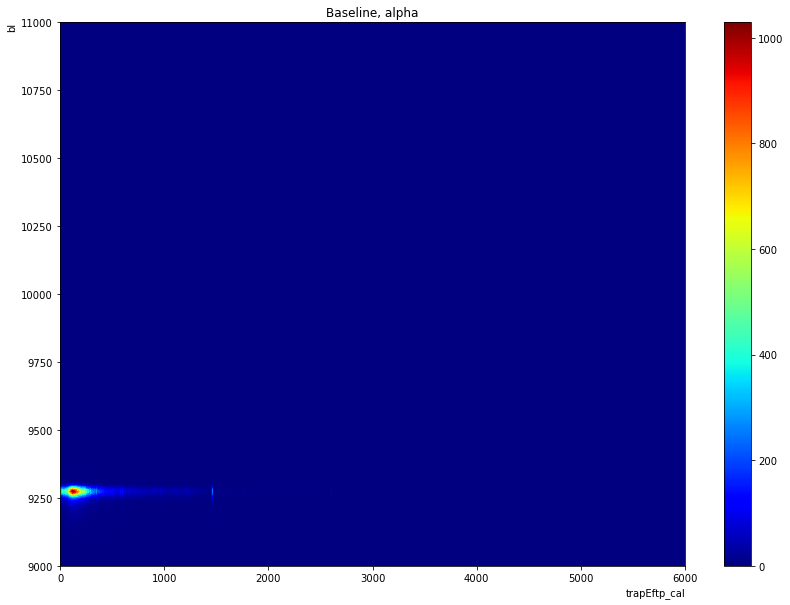

In [12]:
# Baseline vs E
# %matplotlib widget

blo, bhi, bpb = 9000, 11000, 1
nbx = int((ehi-elo)/epb)
nby = int((bhi-blo)/bpb)

h = plt.hist2d(df[etype], df['bl'], bins=[nbx,nby],
                       range=[[elo, ehi], [blo, bhi]], cmap='jet')

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel(f'{etype}', ha='right', x=1)
plt.ylabel('bl', ha='right', y=1)
plt.title('Baseline, alpha')
# plt.tight_layout()
plt.show()

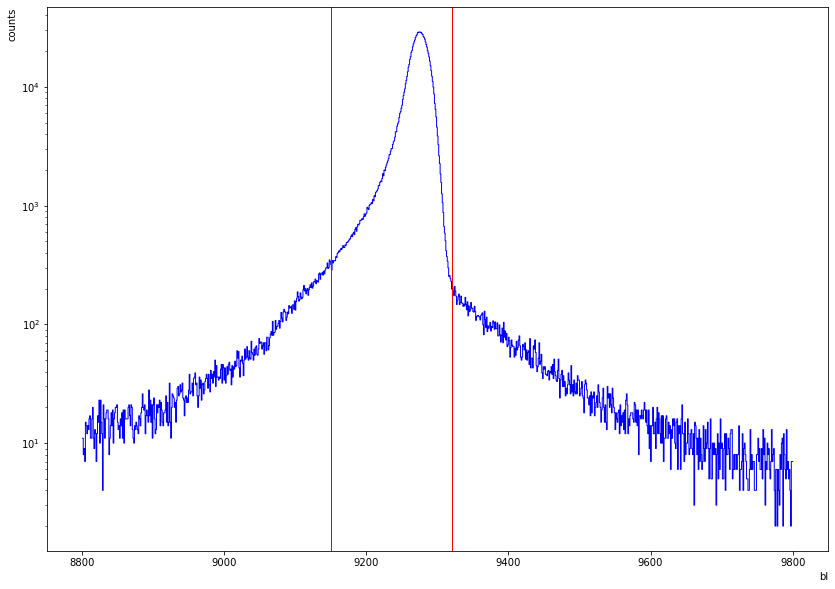

In [13]:
blo, bhi, bpb = 8800, 9800, 1
nbx = int((bhi-blo)/bpb)

bl_hist, bins = np.histogram(df['bl'], bins=nbx,
                range=[blo, bhi])

plt.semilogy(bins[1:], bl_hist, ds='steps', c='b', lw=1)

bl_cut_lo, bl_cut_hi = 9150,9320

plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

In [14]:
# use baseline cut
# energy_cut = (energy > 10) & (energy < 6000)
# bl_cut = (bl> bl_cut_lo) & (bl< bl_cut_hi)
# cut = bl_cut & energy_cut
df_cut = df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi} and trapEftp_cal >500 and trapEftp_cal <6000 ').copy() #and dcr >-30 and dcr < 60
# df_cut = df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi} and trapEftp_cal >55 and trapEftp_cal <65').copy()

if bkg_sub == True:
    bkg_df_cut = bkg_df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi} and trapEftp_cal >50 and trapEftp_cal <6000 ').copy() #and dcr >-30 and dcr < 60
#     bkg_df_cut = df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi} and trapEftp_cal >55 and trapEftp_cal <65').copy()


In [15]:
#dsp_id= 02


alo, ahi, apb= 0.005, 0.075, 0.0001

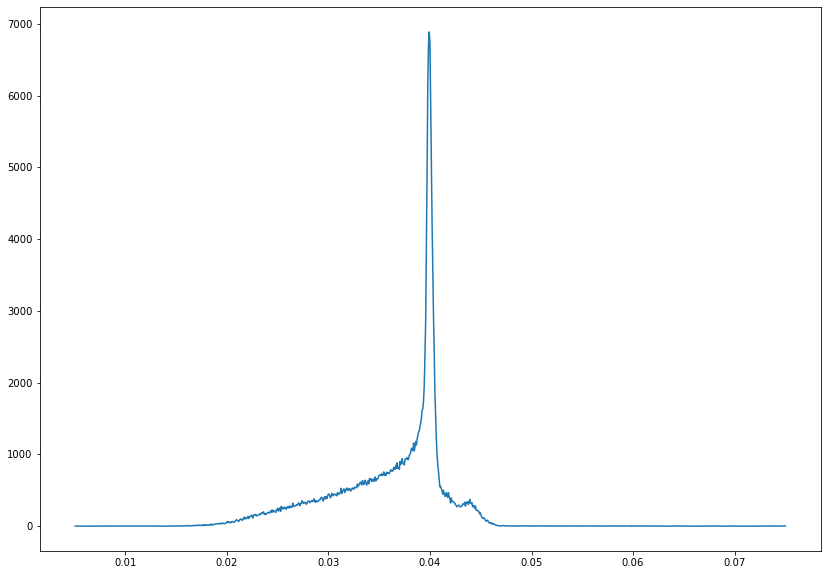

In [16]:
# %matplotlib widget
# 1D AoE hist using Pygama
# nb_AoE = int((ahi-alo)/apb)
nb_AoE = 1000

AoE_hist, AoE_bins, AoE_vars = pgh.get_hist(df_cut['AoE'], bins=nb_AoE, range=[alo, ahi])

plt.plot(AoE_bins[1:], AoE_hist)

plt.show()

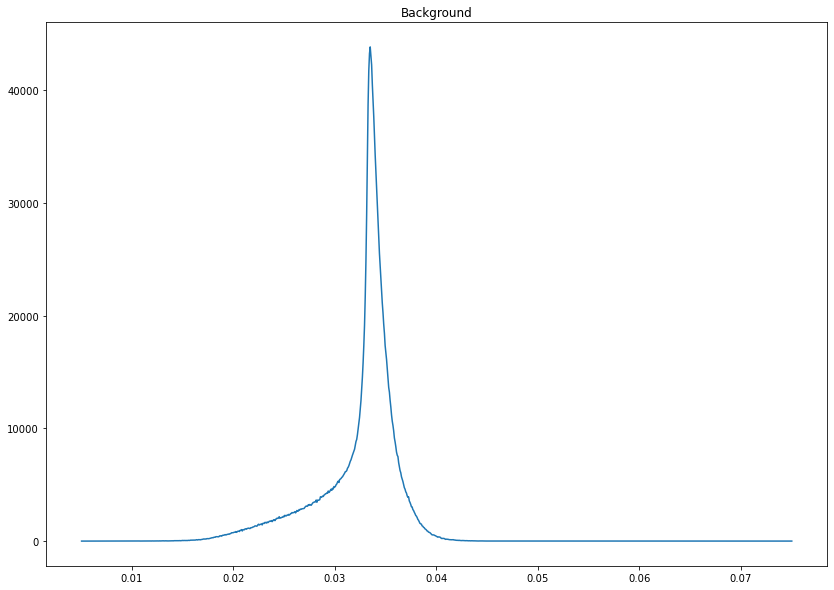

In [17]:
# %matplotlib widget
# 1D AoE hist using Pygama
if bkg_sub==True:
    # nb_AoE = int((ahi-alo)/apb)
    nb_AoE = 1000

    bkg_AoE_hist, bkg_AoE_bins, bkg_AoE_vars = pgh.get_hist(bkg_df_cut['AoE'], bins=nb_AoE, range=[alo, ahi])

    plt.plot(bkg_AoE_bins[1:], bkg_AoE_hist)

    plt.title('Background')

    plt.show()

In [18]:
AoE_pars, AoE_cov = pgf.gauss_mode_width_max(AoE_hist, AoE_bins, AoE_vars)
AoE_mode = AoE_pars[0]
print(f'AoE_mode: {AoE_mode}')

if bkg_sub == True:
    bkg_AoE_pars, bkg_AoE_cov = pgf.gauss_mode_width_max(bkg_AoE_hist, bkg_AoE_bins, bkg_AoE_vars)
    bkg_AoE_mode = bkg_AoE_pars[0]
    print(f'Background AoE_mode: {bkg_AoE_mode}')

AoE_mode: 0.039885964922957956
Background AoE_mode: 0.0334618439435689


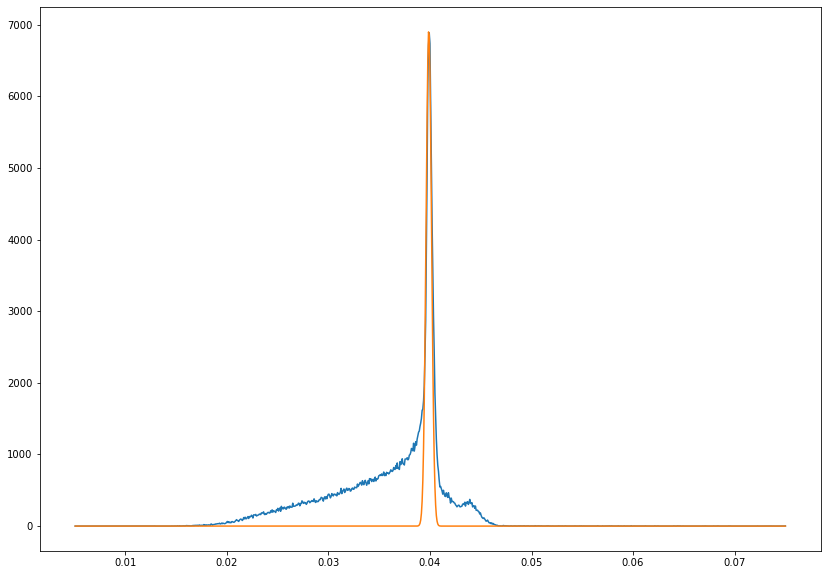

In [19]:
# %matplotlib widget

plt.plot(AoE_bins[1:], AoE_hist)

plt.plot(AoE_bins[1:], pgf.gauss_basic(AoE_bins[1:], *AoE_pars))

plt.show()

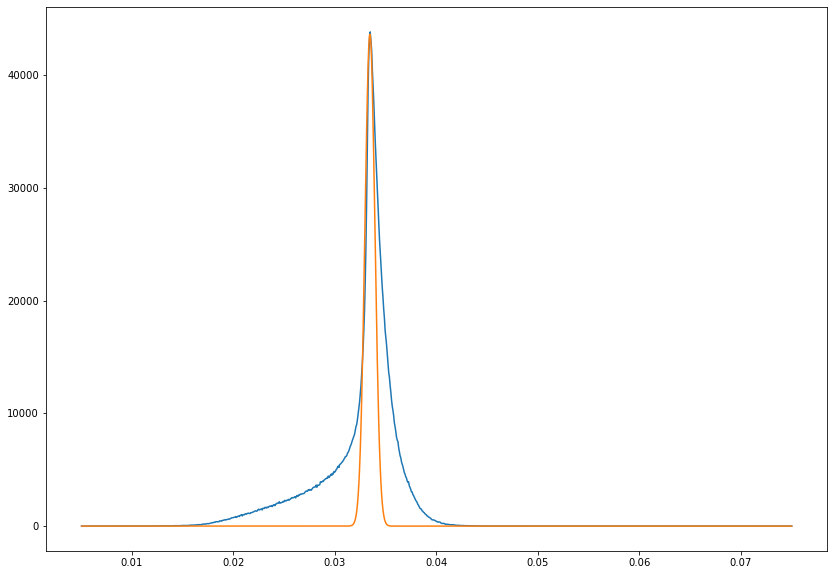

In [20]:
if bkg_sub==True:
    plt.plot(bkg_AoE_bins[1:], bkg_AoE_hist)

    plt.plot(bkg_AoE_bins[1:], pgf.gauss_basic(bkg_AoE_bins[1:], *bkg_AoE_pars))


plt.show()

In [21]:
df_cut['AoE_corr'] = df_cut['AoE'] - AoE_mode

if bkg_sub==True:
    bkg_df_cut['AoE_corr'] = bkg_df_cut['AoE'] - bkg_AoE_mode

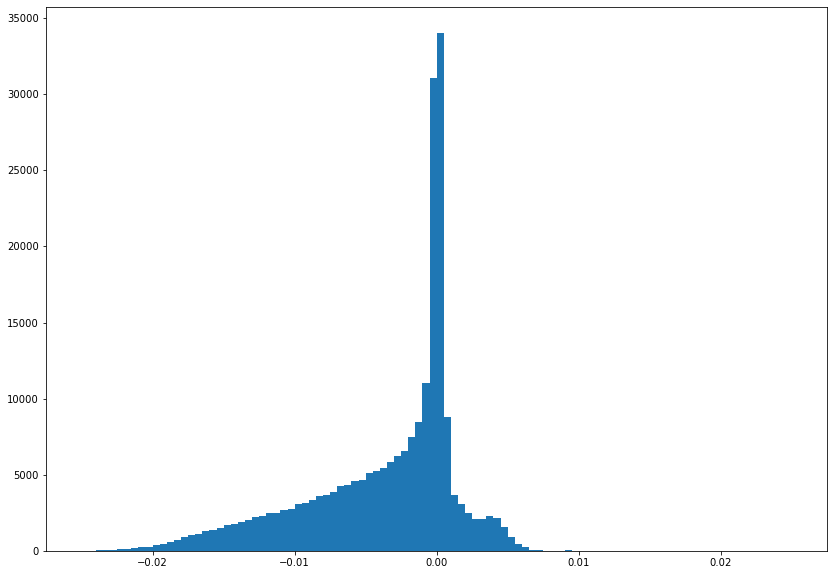

In [22]:
# %matplotlib widget
alo_corr, ahi_corr, apb= -0.025, 0.025, 0.0001
nb_AoE_corr = 100

plt.hist(df_cut['AoE_corr'], bins=nb_AoE_corr, range=[alo_corr, ahi_corr])

plt.show()

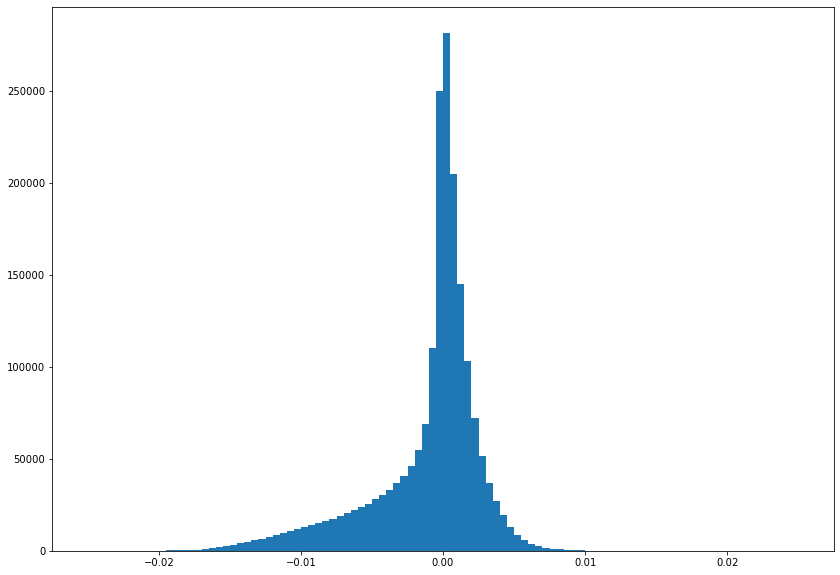

In [23]:
if bkg_sub==True:
    plt.hist(bkg_df_cut['AoE_corr'], bins=nb_AoE_corr, range=[alo_corr, ahi_corr])

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-24-973c8ee23e12>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  a_pcm1 = plt.pcolormesh(aX, aY, aoe_corr_vs_E_hist_norm, norm=LogNorm()) #, norm=LogNorm()


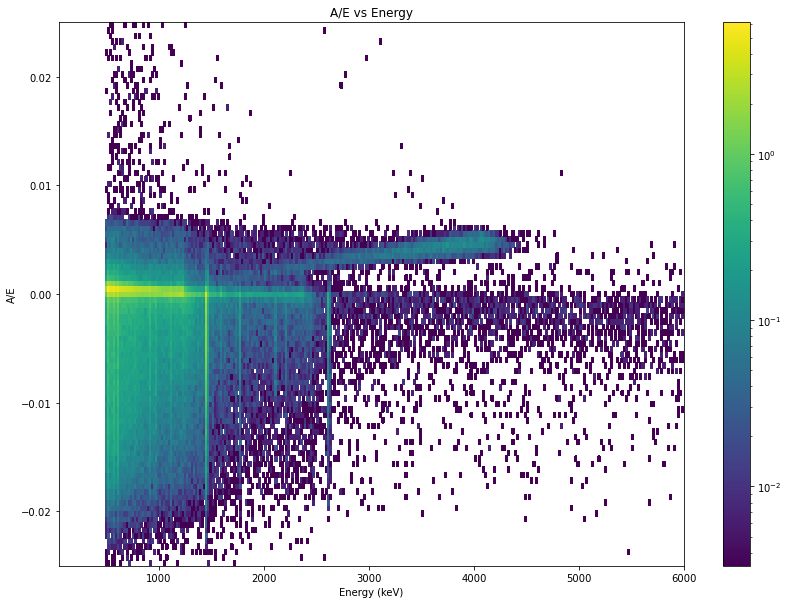

In [24]:
# %matplotlib widget
alo_corr, ahi_corr, apb= -0.025, 0.025, 0.0001
nb_AoE_corr = 100
nb_energy = 299
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

aoe_corr_vs_E_hist_norm, axedges, ayedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['AoE_corr'], bins=[nb_energy, nb_AoE_corr], range=([elo, ehi], [alo_corr, ahi_corr]), weights=wts)

# aoe_corr_vs_E_hist_norm = np.divide(aoe_corr_vs_E_hist, (rt_min))

aX, aY = np.mgrid[elo:ehi:nb_energy*1j, alo_corr:ahi_corr:nb_AoE_corr*1j]

a_pcm1 = plt.pcolormesh(aX, aY, aoe_corr_vs_E_hist_norm, norm=LogNorm()) #, norm=LogNorm()

a_CB1 = plt.colorbar(a_pcm1)

plt.xlabel('Energy (keV)')
plt.ylabel('A/E')
plt.title('A/E vs Energy')
plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-25-6a1e14004778>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  a_pcm2 = plt.pcolormesh(aX, aY, bkg_aoe_corr_vs_E_hist_norm, norm=LogNorm(0.001, 2)) #, norm=(mpl.colors.Normalize(0., 5.))


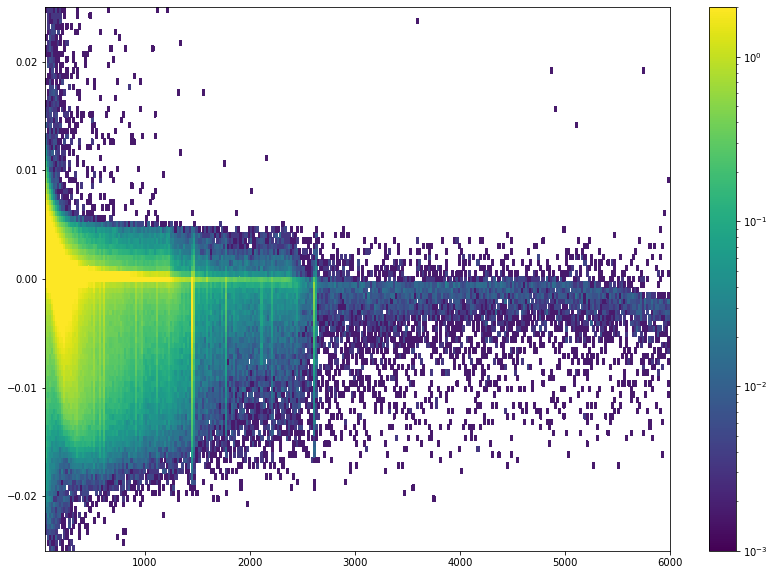

In [25]:

if bkg_sub==True:
    # %matplotlib widget
#     alo_corr, ahi_corr, apb= -0.025, 0.025, 0.0001
#     nb_AoE_corr = 100
#     nb_energy = 599
#     elo = 10
#     ehi = 6000
    #normalize hist by runtime
    bkg_rt = np.array([(1/bkg_rt_min)])
    bkg_wts = np.repeat(bkg_rt, len(bkg_df_cut['trapEftp_cal']))
    print(wts)

    bkg_aoe_corr_vs_E_hist_norm, axedges, ayedges = np.histogram2d(bkg_df_cut['trapEftp_cal'], bkg_df_cut['AoE_corr'], bins=[nb_energy, nb_AoE_corr], range=([elo, ehi], [alo_corr, ahi_corr]), weights = bkg_wts)

#     bkg_aoe_corr_vs_E_hist_norm = np.divide(bkg_aoe_corr_vs_E_hist, (bkg_rt_min))

    aX, aY = np.mgrid[elo:ehi:nb_energy*1j, alo_corr:ahi_corr:nb_AoE_corr*1j]

    a_pcm2 = plt.pcolormesh(aX, aY, bkg_aoe_corr_vs_E_hist_norm, norm=LogNorm(0.001, 2)) #, norm=(mpl.colors.Normalize(0., 5.))

    a_CB2 = plt.colorbar(a_pcm2)
    plt.show()

759.6153599461935
3248.738419022703
-2489.12305907651


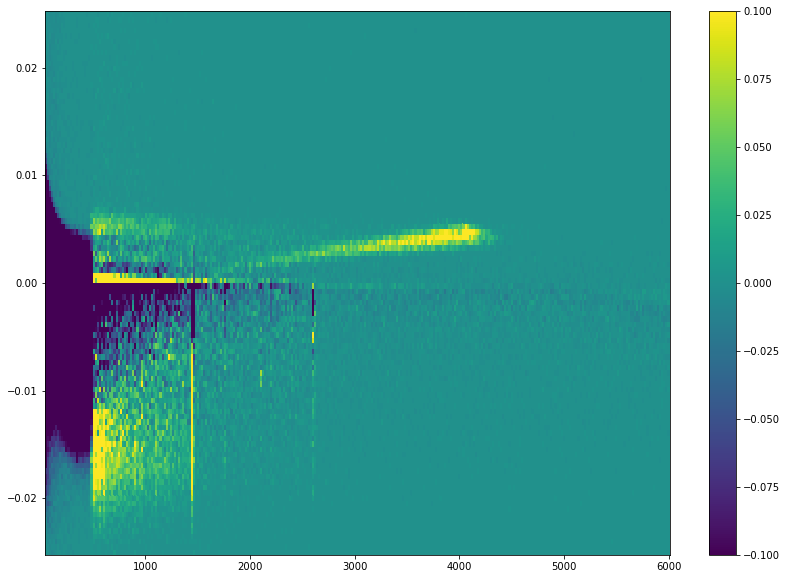

In [26]:
import matplotlib as mpl
if bkg_sub==True:
    alp_bkg = aoe_corr_vs_E_hist_norm - bkg_aoe_corr_vs_E_hist_norm
    print(np.sum(aoe_corr_vs_E_hist_norm))
    print(np.sum(bkg_aoe_corr_vs_E_hist_norm))
    print(np.sum(alp_bkg))
    
    a_pcm3 = plt.pcolormesh(aX, aY, alp_bkg, shading='auto', norm=mpl.colors.Normalize(-0.1, 0.1)) #, norm=LogNorm(), norm=mpl.colors.Normalize(-0.01, 0.1)
    a_CB3 = plt.colorbar(a_pcm3)
#     plt.xlim(0, 500)
    plt.show()

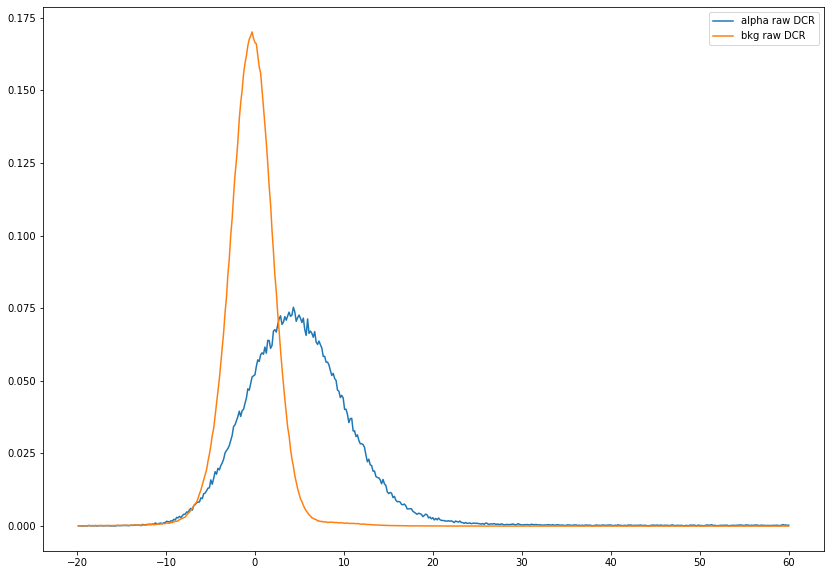

In [27]:
# %matplotlib widget
# 1D AoE hist using Pygama
# nb_AoE = int((ahi-alo)/apb)
dlo, dhi, dpb = -20., 60, 0.1 
nb_dcr = 500

raw_dcr_hist, raw_dcr_bins = np.histogram(df_cut['dcr'], bins=nb_dcr, range=[dlo, dhi], density=True)
# raw_dcr_hist, raw_dcr_bins, raw_dcr_vars = pgh.get_hist(df_cut['dcr'], bins=nb_dcr, range=[dlo, dhi])

plt.plot(raw_dcr_bins[1:], raw_dcr_hist, label='alpha raw DCR')

if bkg_sub==True:
    bkg_raw_dcr_hist, bkg_raw_dcr_bins = np.histogram(bkg_df_cut['dcr'], bins=nb_dcr, range=[dlo, dhi], density=True)
#     bkg_raw_dcr_hist, bkg_raw_dcr_bins, bkg_raw_dcr_vars = pgh.get_hist(bkg_df_cut['dcr'], bins=nb_dcr, range=[dlo, dhi])
    
    
    plt.plot(bkg_raw_dcr_bins[1:], bkg_raw_dcr_hist, label='bkg raw DCR')
    
    plt.legend()

plt.show()

In [28]:
#creat new DCR
if (dsp_id == '01'):
    const = 0.0011
elif (dsp_id == '02'):
    const  = 0.0002 

df_cut['dcr_linoff'] = df_cut['dcr'] + const*df_cut['trapEftp']

if bkg_sub==True:
    bkg_df_cut['dcr_linoff'] = bkg_df_cut['dcr'] + const*df_cut['trapEftp']

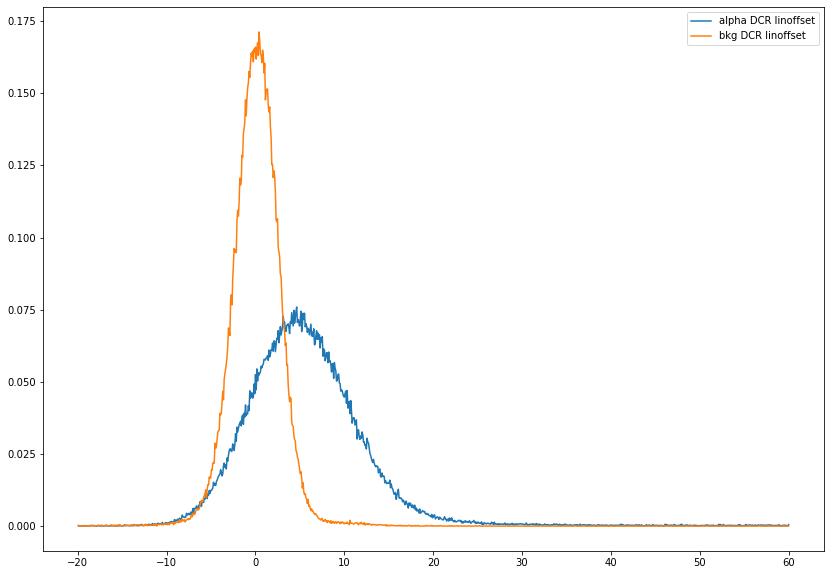

In [29]:
# %matplotlib widget
# 1D AoE hist using Pygama
# nb_AoE = int((ahi-alo)/apb)
nb_dcr = 1000

dcr_hist, dcr_bins = np.histogram(df_cut['dcr_linoff'], bins=nb_dcr, range=[dlo, dhi], density=True)
# dcr_hist, dcr_bins, dcr_vars = pgh.get_hist(df_cut['dcr_linoff'], bins=nb_dcr, range=[dlo, dhi])

plt.plot(dcr_bins[1:], dcr_hist, label='alpha DCR linoffset')

if bkg_sub==True:
    bkg_dcr_hist, bkg_dcr_bins = np.histogram(bkg_df_cut['dcr_linoff'], bins=nb_dcr, range=[dlo, dhi], density=True)
#     bkg_dcr_hist, bkg_dcr_bins, bkg_dcr_vars = pgh.get_hist(bkg_df_cut['dcr_linoff'], bins=nb_dcr, range=[dlo, dhi])

    plt.plot(bkg_dcr_bins[1:], bkg_dcr_hist, label='bkg DCR linoffset')
    
    plt.legend()

plt.show()

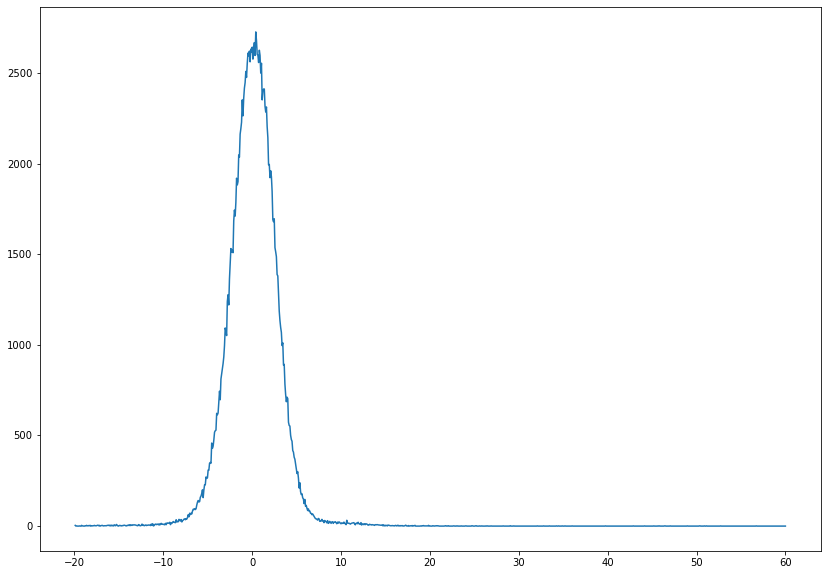

In [30]:
if bkg_sub==True:
    bkg_dcr_hist, bkg_dcr_bins, bkg_dcr_vars = pgh.get_hist(bkg_df_cut['dcr_linoff'], bins=nb_dcr, range=[dlo, dhi])

    plt.plot(bkg_dcr_bins[1:], bkg_dcr_hist)

plt.show()

In [31]:
# dcr_pars, dcr_cov = pgf.gauss_mode_width_max(dcr_hist, dcr_bins, dcr_vars, n_bins=50)
dcr_pars, dcr_cov = pgf.gauss_mode_width_max(raw_dcr_hist, raw_dcr_bins, n_bins=20)
dcr_mode = dcr_pars[0]
dcr_width = dcr_pars[1]
print(dcr_mode)
print(dcr_width)

if bkg_sub==True:
#     bkg_dcr_pars, bkg_dcr_cov = pgf.gauss_mode_width_max(bkg_dcr_hist, bkg_dcr_bins, bkg_dcr_vars, n_bins=50)
    bkg_dcr_pars, bkg_dcr_cov = pgf.gauss_mode_width_max(bkg_raw_dcr_hist, bkg_raw_dcr_bins, n_bins=20)
    bkg_dcr_mode = bkg_dcr_pars[0]
    bkg_dcr_width = bkg_dcr_pars[1]
    print(f'background dcr_mode: {bkg_dcr_mode}')
    print(f'background dcr_width:{bkg_dcr_width}')

3.9574787423493785
4.329231935691532
background dcr_mode: -0.40953742323540665
background dcr_width:2.302674747742399


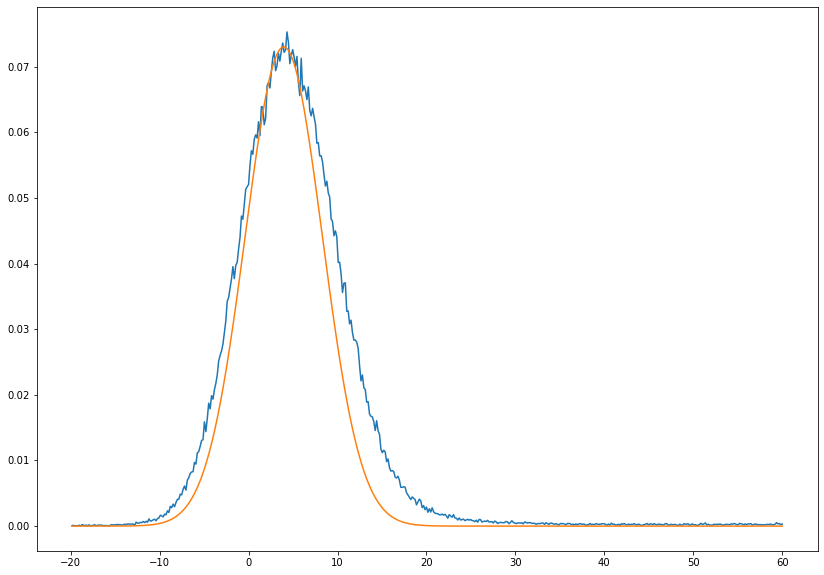

In [32]:
# %matplotlib widget
plt.plot(raw_dcr_bins[1:], raw_dcr_hist)

plt.plot(raw_dcr_bins[1:], pgf.gauss_basic(raw_dcr_bins[1:], *dcr_pars))

plt.show()

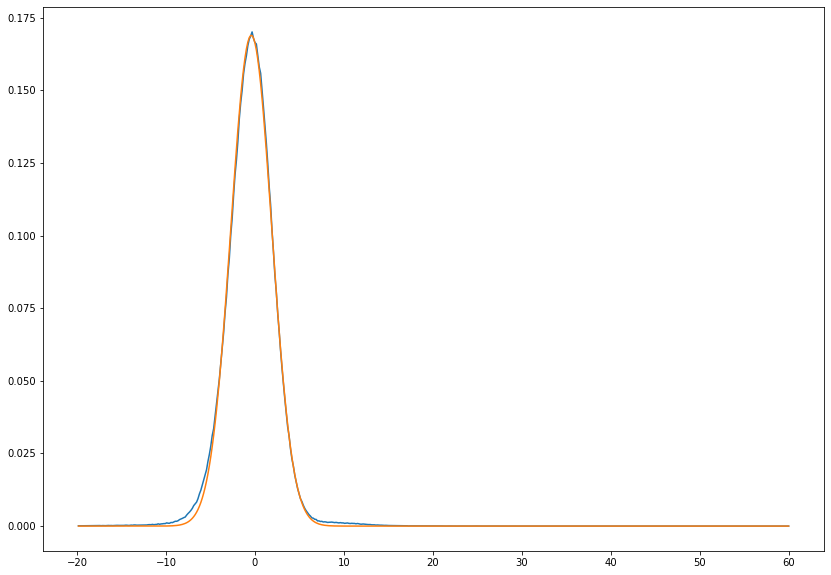

In [33]:
if bkg_sub==True:
    plt.plot(bkg_raw_dcr_bins[1:], bkg_raw_dcr_hist)

    plt.plot(bkg_raw_dcr_bins[1:], pgf.gauss_basic(bkg_raw_dcr_bins[1:], *bkg_dcr_pars))

plt.show()

In [34]:
dcr_offset = dcr_mode
# df_cut['dcr_corr'] = (df_cut['dcr_linoff'] - dcr_offset)/(dcr_width)
df_cut['dcr_corr'] = (df_cut['dcr'] - dcr_offset)

if bkg_sub==True:
    bkg_dcr_offset = bkg_dcr_mode
#     bkg_df_cut['dcr_corr'] = (bkg_df_cut['dcr_linoff'] - bkg_dcr_offset)/(bkg_dcr_width)
    bkg_df_cut['dcr_corr'] = (bkg_df_cut['dcr'] - bkg_dcr_offset)

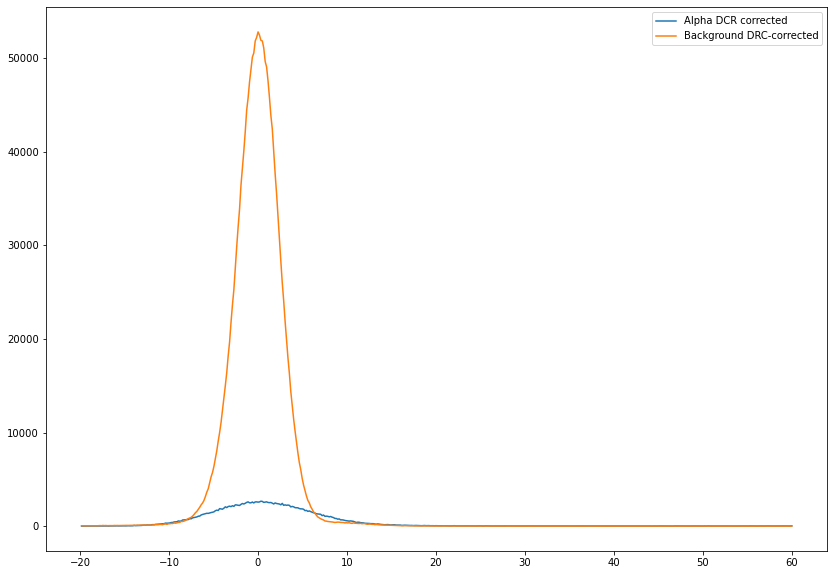

In [35]:
# %matplotlib widget
nb_dcr_corr = 500
dlo_corr = -20
dhi_corr = 60
dcr_corr_hist, dcr_corr_bins, dcr_corr_vars = pgh.get_hist(df_cut['dcr_corr'], bins=nb_dcr_corr, range=[dlo_corr, dhi_corr])

plt.plot(dcr_corr_bins[1:], dcr_corr_hist, label='Alpha DCR corrected')
# plt.xlim(-10, 10)

if bkg_sub==True:
    bkg_dcr_corr_hist, bkg_dcr_corr_bins, bkg_dcr_corr_vars = pgh.get_hist(bkg_df_cut['dcr_corr'], bins=nb_dcr_corr, range=[dlo_corr, dhi_corr])

    plt.plot(bkg_dcr_corr_bins[1:], bkg_dcr_corr_hist, label='Background DRC-corrected')

plt.legend()
# plt.xlim(-5,5)
plt.show()

In [36]:
norm_dcr_corr_hist = np.divide(dcr_corr_hist, rt_min)

if bkg_sub == True:
    bkg_norm_dcr_corr_hist = np.divide(bkg_dcr_corr_hist, bkg_rt_min)
    bkg_sub_dcr = norm_dcr_corr_hist - bkg_norm_dcr_corr_hist

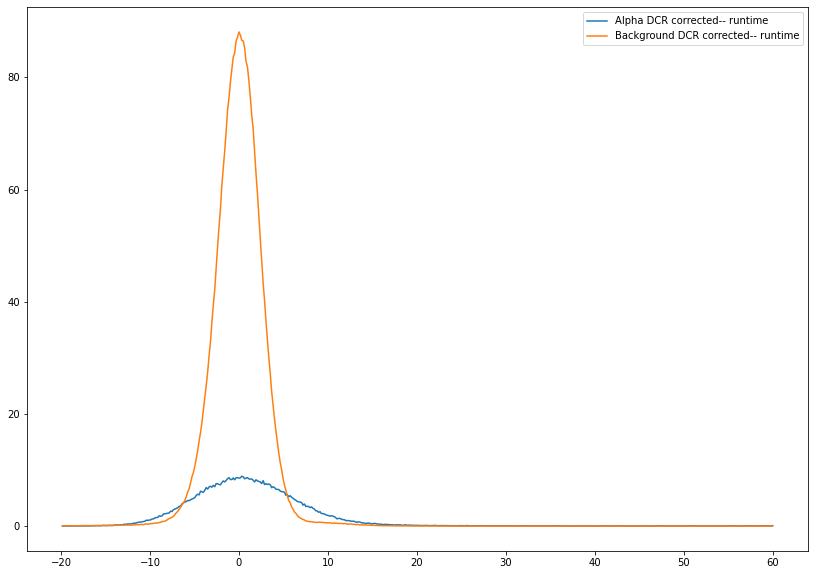

In [37]:
plt.plot(dcr_corr_bins[1:], norm_dcr_corr_hist, label='Alpha DCR corrected-- runtime')

if bkg_sub ==True:
    plt.plot(bkg_dcr_corr_bins[1:], bkg_norm_dcr_corr_hist, label='Background DCR corrected-- runtime')
    
plt.legend()

# plt.xlim(-5,5)
plt.show()

In [38]:
raw_lh5_dir = dg.lh5_dir
raw_list = raw_lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']

print(raw_list)

867    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
868    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
869    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
870    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
871    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
872    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
873    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
874    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
875    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
876    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
dtype: object


In [39]:
bkg_raw_lh5_dir = bkg_dg.lh5_dir
bkg_raw_list = bkg_raw_lh5_dir + bkg_dg.fileDB['raw_path'] + '/' + bkg_dg.fileDB['raw_file']

print(bkg_raw_list)

678    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
679    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
680    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
681    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
682    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
683    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
684    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
685    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
686    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
687    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
688    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
689    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
690    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
691    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
692    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
693    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
694    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
695    /global/cfs/cdirs/m2676/

In [40]:
# cut = 

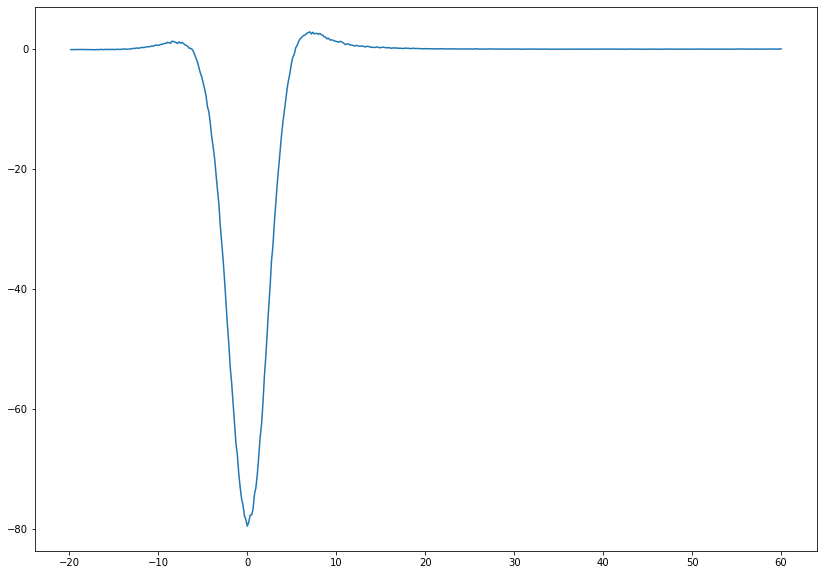

In [41]:
# %matplotlib widget
if bkg_sub==True:
    plt.plot(bkg_dcr_corr_bins[1:], bkg_sub_dcr)

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-42-92c0b99934f2>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(XX, YY, dcr_corr_vs_E_hist_norm, norm=LogNorm())


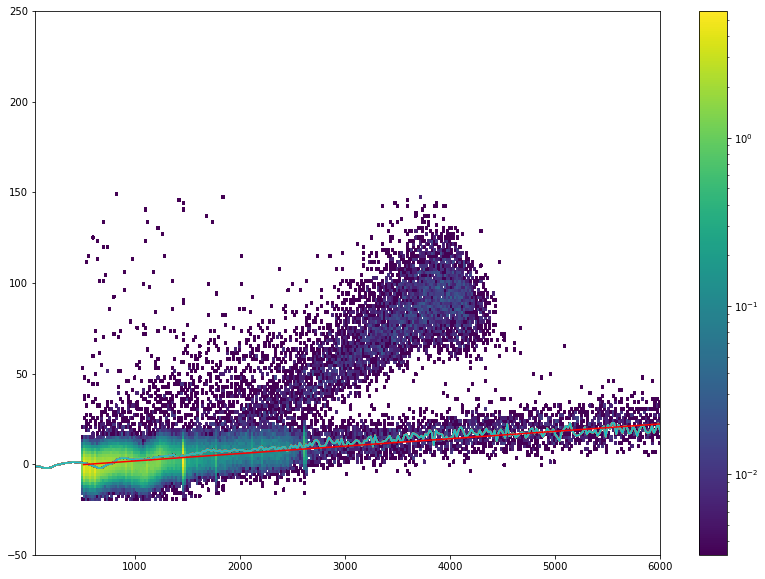

In [42]:
# %matplotlib widget
fit_dcr = True

nb_dcr_corr = 100 #500
dlo_corr_norm, dhi_corr_norm = -20, 150
nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

dcr_corr_vs_E_hist_norm, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr_corr'], bins=[nb_energy, nb_dcr_corr], range=([elo, ehi], [dlo_corr_norm, dhi_corr_norm]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX, YY = np.mgrid[elo:ehi:nb_energy*1j, dlo_corr_norm:dhi_corr_norm:nb_dcr_corr*1j]

pcm1 = plt.pcolormesh(XX, YY, dcr_corr_vs_E_hist_norm, norm=LogNorm())

df_cut_dcr = df_cut.query(f'dcr >-30 and dcr < 30').copy() #and dcr >-30 and dcr < 60

if fit_dcr==True:
    
    median, xedges, binnumber = stats.binned_statistic(df_cut_dcr['trapEftp_cal'], df_cut_dcr['dcr_corr'], statistic = "median", bins = nb_energy)
    pcm1_fit = plt.plot(XX, median)
    en_bin_centers = pgh.get_bin_centers(xedges)
    fit = np.polyfit(en_bin_centers, median, deg=1)
    # print( len(median))
    # print( len(pgh.get_bin_centers(bkg_xedges)))
    
    y = fit[0]*en_bin_centers + fit[1]
    plt.plot(en_bin_centers, y, 'r')
#     print(fit)


CB = plt.colorbar(pcm1)
# plt.ylim(-20, 40)
plt.ylim(-50, 250)
plt.show()



[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-43-08ed6fd7cb9a>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm_linOff = plt.pcolormesh(XX_linOff, YY_linOff, dcr_linOff_vs_E_hist_norm, norm=LogNorm(0.001, 2))


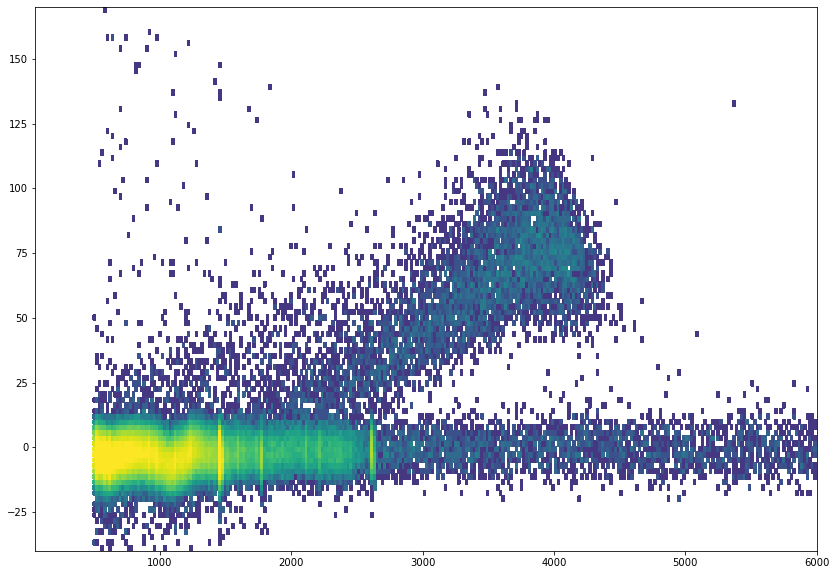

In [43]:
const = fit[0]
offset = fit[1]
df_cut['dcr_linoff'] = df_cut['dcr_corr'] + ((-1*const))*df_cut['trapEftp_cal']

# fit_dcr = True

nb_dcr_linOff = 100 #500
dlo_linOff_norm, dhi_linOff_norm = -40, 170
nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

dcr_linOff_vs_E_hist_norm, linOff_xedges, linOffyedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr_linoff'], bins=[nb_energy, nb_dcr_linOff], range=([elo, ehi], [dlo_linOff_norm, dhi_linOff_norm]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_linOff, YY_linOff = np.mgrid[elo:ehi:nb_energy*1j, dlo_linOff_norm:dhi_linOff_norm:nb_dcr_linOff*1j]

pcm_linOff = plt.pcolormesh(XX_linOff, YY_linOff, dcr_linOff_vs_E_hist_norm, norm=LogNorm(0.001, 2))

# plt.ylim(-5000, 2000)

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-44-96b10837a665>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_raw = plt.pcolormesh(XX_raw, YY_raw, dcr_raw_vs_E_hist_norm, norm=LogNorm())


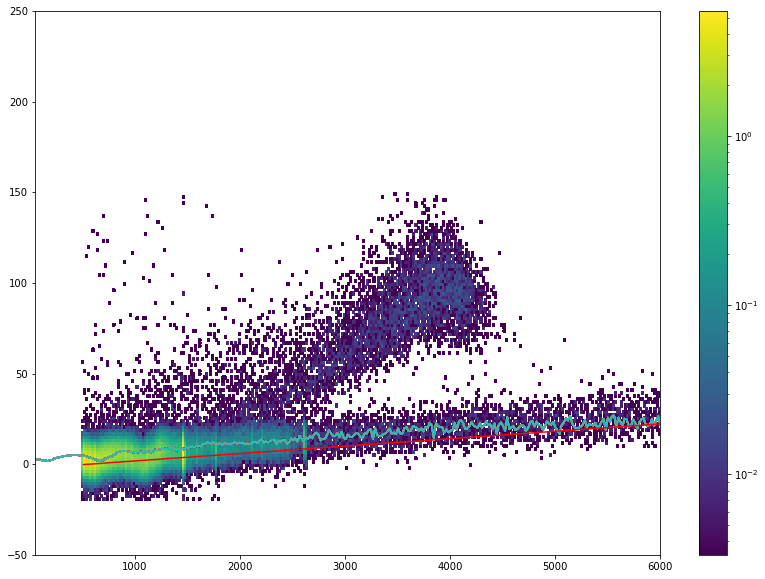

In [44]:
# %matplotlib widget
fit_dcr = True

nb_dcr = 100 #500
dlo_norm, dhi_norm = -20, 150
nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

dcr_raw_vs_E_hist_norm, raw_xedges, raw_yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr'], bins=[nb_energy, nb_dcr], range=([elo, ehi], [dlo_norm, dhi_norm]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_raw, YY_raw = np.mgrid[elo:ehi:nb_energy*1j, dlo_norm:dhi_norm:nb_dcr*1j]

pcm1_raw = plt.pcolormesh(XX_raw, YY_raw, dcr_raw_vs_E_hist_norm, norm=LogNorm())

df_cut_dcr_raw = df_cut.query(f'dcr >-30 and dcr < 30').copy() #and dcr >-30 and dcr < 60

if fit_dcr==True:
    
    median, xedges, binnumber = stats.binned_statistic(df_cut_dcr_raw['trapEftp_cal'], df_cut_dcr_raw['dcr'], statistic = "median", bins = nb_energy)
    pcm1_fit = plt.plot(XX_raw, median)
    raw_en_bin_centers = pgh.get_bin_centers(xedges)
    fit_raw = np.polyfit(raw_en_bin_centers, median, deg=1)
    # print( len(median))
    # print( len(pgh.get_bin_centers(bkg_xedges)))
    
    y = fit_raw[0]*raw_en_bin_centers + fit[1]
    plt.plot(raw_en_bin_centers, y, 'r')
#     print(fit)


CB = plt.colorbar(pcm1_raw)
# plt.ylim(-20, 40)
plt.ylim(-50, 250)
plt.show()


[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-45-87e31664ca11>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm_linOff_raw = plt.pcolormesh(XX_linOff_raw, YY_linOff_raw, dcr_linOff_raw_vs_E_hist_norm, norm=LogNorm())


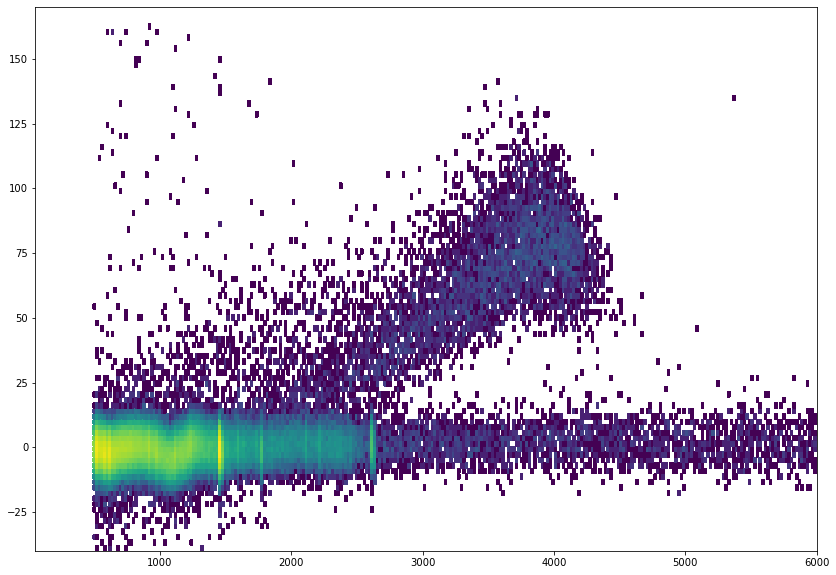

In [45]:
const = fit_raw[0]
offset = fit_raw[1]
df_cut['dcr_raw_linoff'] = df_cut['dcr']-offset + ((-1*const))*df_cut['trapEftp_cal']

# fit_dcr = True

nb_dcr_linOff_raw = 100 #500
dlo_linOff_raw_norm, dhi_linOff_raw_norm = -40, 170
nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

dcr_linOff_raw_vs_E_hist_norm, linOff_xedges, linOffyedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr_raw_linoff'], bins=[nb_energy, nb_dcr_linOff], range=([elo, ehi], [dlo_linOff_norm, dhi_linOff_norm]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_linOff_raw, YY_linOff_raw = np.mgrid[elo:ehi:nb_energy*1j, dlo_linOff_raw_norm:dhi_linOff_raw_norm:nb_dcr_linOff_raw*1j]

pcm_linOff_raw = plt.pcolormesh(XX_linOff_raw, YY_linOff_raw, dcr_linOff_raw_vs_E_hist_norm, norm=LogNorm())

# plt.ylim(-5000, 2000)

plt.show()

[0.00166736 0.00166736 0.00166736 ... 0.00166736 0.00166736 0.00166736]


<ipython-input-46-c92b2f0ff7e0>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(XX, YY, bkg_dcr_corr_vs_E_hist_norm, norm=LogNorm())


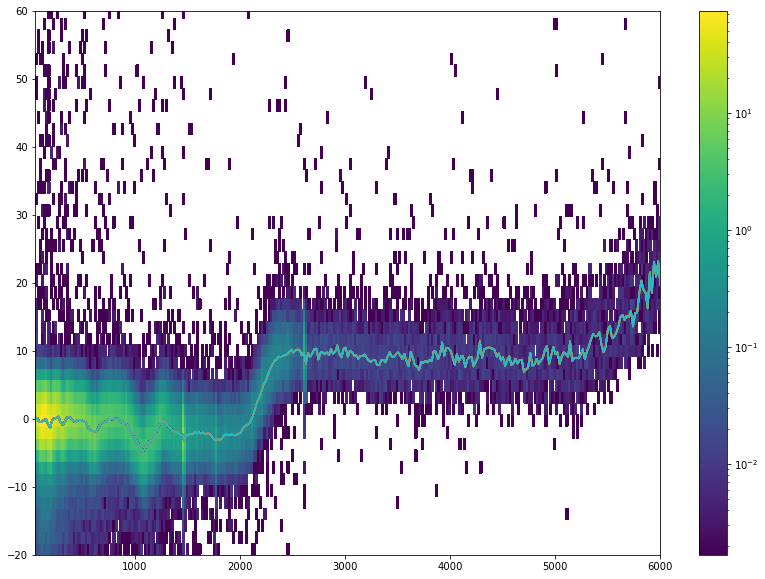

In [46]:
if bkg_sub ==True:
    
    #normalize hist by runtime
    bkg_rt = np.array([(1/bkg_rt_min)])
    bkg_wts = np.repeat(bkg_rt, len(bkg_df_cut['trapEftp_cal']))
    print(bkg_wts)
    bkg_dcr_corr_vs_E_hist_norm, bkg_xedges, bkg_yedges = np.histogram2d(bkg_df_cut['trapEftp_cal'], (bkg_df_cut['dcr']), bins=[nb_energy, nb_dcr_corr], range=([elo, ehi], [dlo_corr_norm, dhi_corr_norm]), weights=bkg_wts)
#     bkg_dcr_corr_vs_E_hist_norm = np.divide(bkg_dcr_corr_vs_E_hist, bkg_rt_min)

    pcm2 = plt.pcolormesh(XX, YY, bkg_dcr_corr_vs_E_hist_norm, norm=LogNorm())
    
    median, xedges, binnumber = stats.binned_statistic(bkg_df_cut['trapEftp_cal'], bkg_df_cut['dcr'], statistic = "median", bins = nb_energy)
    
    pcm3 = plt.plot(XX, median)

    CB = plt.colorbar(pcm2)
    plt.ylim(-20, 60)
    plt.show()

In [47]:
en_bin_centers = pgh.get_bin_centers(bkg_xedges)
fit = np.polyfit(en_bin_centers, median, deg=1)
# print( len(median))
# print( len(pgh.get_bin_centers(bkg_xedges)))
print(fit)

[ 3.07937105e-03 -3.27267489e+00]


In [48]:
#creat new DCR
if (dsp_id == '01'):
    const = 0.0011
elif (dsp_id == '02'):
    const  = 0.0002 
    
const = fit[0]
offset = -1*fit[1]
df_cut['dcr_linoff'] = df_cut['dcr'] + const*df_cut['trapEftp']

if bkg_sub==True:
    bkg_df_cut['dcr_linoff'] = bkg_df_cut['dcr'] + df_cut['trapEftp']*(-1*const) + offset

[0.00166736 0.00166736 0.00166736 ... 0.00166736 0.00166736 0.00166736]


<ipython-input-49-95995dff494e>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(XX, YY, bkg_dcr_corr_vs_E_hist_norm, norm=LogNorm())


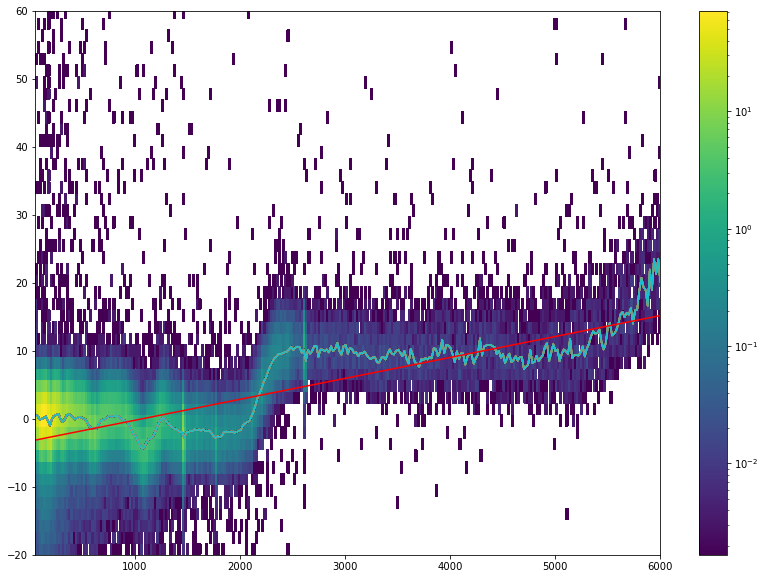

In [49]:
if bkg_sub ==True:
    
    #normalize hist by runtime
    bkg_rt = np.array([(1/bkg_rt_min)])
    bkg_wts = np.repeat(bkg_rt, len(bkg_df_cut['trapEftp_cal']))
    print(bkg_wts)
    bkg_dcr_corr_vs_E_hist_norm, bkg_xedges, bkg_yedges = np.histogram2d(bkg_df_cut['trapEftp_cal'], (bkg_df_cut['dcr_corr']), bins=[nb_energy, nb_dcr_corr], range=([elo, ehi], [dlo_corr_norm, dhi_corr_norm]), weights=bkg_wts)
#     bkg_dcr_corr_vs_E_hist_norm = np.divide(bkg_dcr_corr_vs_E_hist, bkg_rt_min)

    pcm2 = plt.pcolormesh(XX, YY, bkg_dcr_corr_vs_E_hist_norm, norm=LogNorm())
    
    median, xedges, binnumber = stats.binned_statistic(bkg_df_cut['trapEftp_cal'], bkg_df_cut['dcr_corr'], statistic = "median", bins = nb_energy)
    
    pcm3 = plt.plot(XX, median)
    y = fit[0]*en_bin_centers + fit[1]
    plt.plot(en_bin_centers, y, 'r')
#     plt.hlines(0, elo, ehi, colors='r')

    CB = plt.colorbar(pcm2)
    plt.ylim(-20, 60)
    plt.show()

[0.00166736 0.00166736 0.00166736 ... 0.00166736 0.00166736 0.00166736]


<ipython-input-50-2e69dcc1d461>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(xx, yy, bkg_dcr_corr_vs_E_hist_norm, norm=LogNorm())


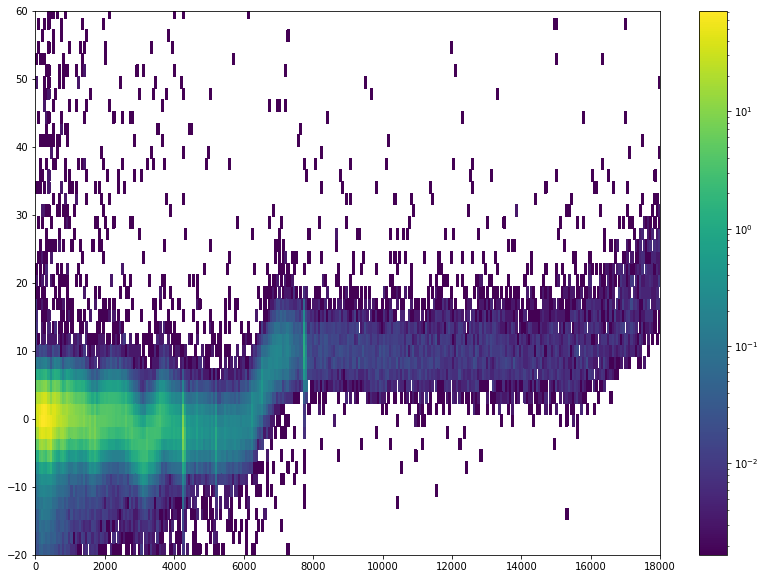

In [50]:
if bkg_sub ==True:
    
    #normalize hist by runtime
    bkg_rt = np.array([(1/bkg_rt_min)])
    bkg_wts = np.repeat(bkg_rt, len(bkg_df_cut['trapEmax']))
    print(bkg_wts)
    trapEmax_bkg_dcr_corr_vs_E_hist_norm, bkg_xedges, bkg_yedges = np.histogram2d(bkg_df_cut['trapEmax'], (bkg_df_cut['dcr_corr']), bins=[nb_energy, nb_dcr_corr], range=([0, 18000], [dlo_corr_norm, dhi_corr_norm]), weights=bkg_wts)
#     bkg_dcr_corr_vs_E_hist_norm = np.divide(bkg_dcr_corr_vs_E_hist, bkg_rt_min)

    xx, yy = np.mgrid[0:18000:nb_energy*1j, dlo_corr_norm:dhi_corr_norm:nb_dcr_corr*1j]

    pcm2 = plt.pcolormesh(xx, yy, bkg_dcr_corr_vs_E_hist_norm, norm=LogNorm())
    
#     median, xedges, binnumber = stats.binned_statistic(bkg_df_cut['trapEmax'], bkg_df_cut['dcr_corr'], statistic = "median", bins = nb_energy)
    
#     pcm3 = plt.plot(XX, median)
#     y = fit[0]*en_bin_centers + fit[1]
#     plt.plot(en_bin_centers, y, 'r')
# #     plt.hlines(0, elo, ehi, colors='r')

    CB = plt.colorbar(pcm2)
    plt.ylim(-20, 60)
    plt.show()

<ipython-input-51-23c661916b2b>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm3 = plt.pcolormesh(XX, YY, bkg_sub_dcr_vs_E, norm=mpl.colors.Normalize(0., 0.03)) #, norm=LogNorm(), norm=mpl.colors.Normalize(-0.1, 0.1)


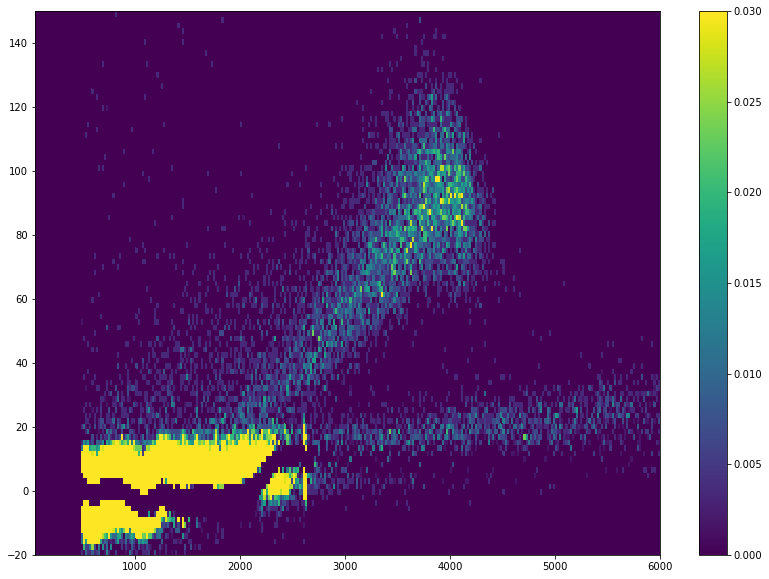

In [51]:
if bkg_sub == True:
    bkg_sub_dcr_vs_E = dcr_corr_vs_E_hist_norm - bkg_dcr_corr_vs_E_hist_norm
    
    pcm3 = plt.pcolormesh(XX, YY, bkg_sub_dcr_vs_E, norm=mpl.colors.Normalize(0., 0.03)) #, norm=LogNorm(), norm=mpl.colors.Normalize(-0.1, 0.1)

    CB = plt.colorbar(pcm3)
    plt.show()

<ipython-input-52-492f370d5377>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X2, Y2, dcr_corr_vs_E_hist_norm, norm=LogNorm())


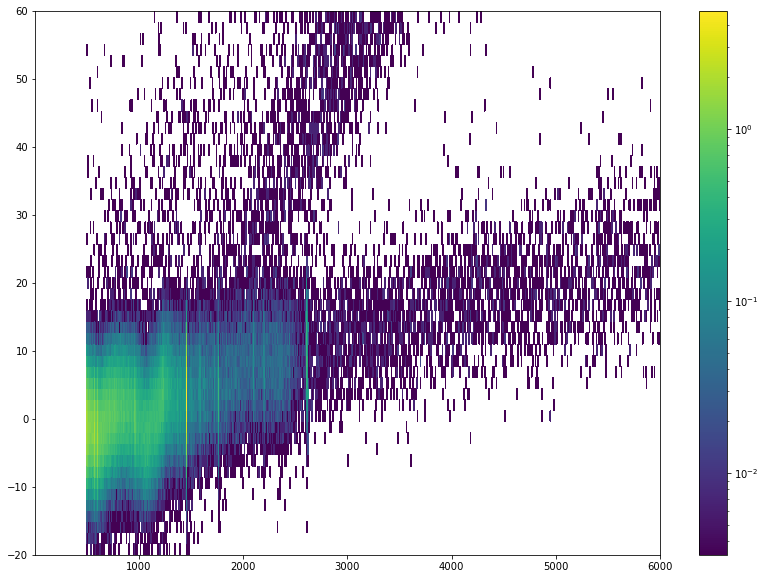

In [52]:
# %matplotlib widget
nb_dcr_corr = 50
nb_energy = 599
elo = 10
ehi = 6000

dcr_corr_vs_E_hist, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr_corr'], bins=[800, nb_dcr_corr], range=([elo, ehi], [dlo_corr, dhi_corr]))

X2, Y2 = np.mgrid[elo:ehi:800*1j, dlo_corr:dhi_corr:nb_dcr_corr*1j]

dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

pcm2 = plt.pcolormesh(X2, Y2, dcr_corr_vs_E_hist_norm, norm=LogNorm())

CB = plt.colorbar(pcm2)
plt.show()

In [53]:
raw_lh5_dir = dg.lh5_dir
raw_list = raw_lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']

print(raw_list)

if bkg_sub ==True:
    bkg_raw_lh5_dir = bkg_dg.lh5_dir
    bkg_raw_list = bkg_raw_lh5_dir + bkg_dg.fileDB['raw_path'] + '/' + bkg_dg.fileDB['raw_file']
    print(bkg_raw_list)

867    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
868    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
869    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
870    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
871    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
872    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
873    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
874    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
875    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
876    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
dtype: object
678    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
679    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
680    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
681    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
682    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
683    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
684    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
685    /global/cf

In [54]:
##### energy cut 
etype = 'trapEftp_cal'
energy = df[etype]

if cal == True:
    # energy = df['trapEmax_cal']
    energy_cut = (energy > 1450) & (energy < 1470) # 1460 peak
    # energy_cut = (energy > 500) & (energy < 600) # 1460 peak
    
else:
    # energy = df_hit['trapEmax']
    # energy_cut = (energy > 2805) & (energy < 2835) # 1460 peak, uncalibratedm trapEmax
    # energy_cut = (energy > 2000000) & (energy < 2500000) #where alphas seem to be in run 117, raw energy parameter
    energy_cut = (energy > 200) & (energy < 1000) #where low e weirdness is in DCR, in trapEftp
    
# print(type(energy))
# print(energy_cut)
# print(energy_cut.value_counts())

bl = df['bl']
dcr = df['dcr']
bl_cut = (bl > bl_cut_lo) & (bl < bl_cut_hi)

# dcr_cut = (dcr>30) & (dcr<140) #accept alphas
dcr_cut = (dcr>20) & (dcr<40) # weird population

tail_slope = df['log_tail_fit_slope']

tail_slope_cut = (tail_slope > -0.000051 ) & (tail_slope < -0.0000505) #weird population

ToE = df['ToE']

ToE_cut =  (ToE > 0.5 ) & (ToE < 1.0) #weird population

# cut = bl_cut  & dcr_cut & tail_slope_cut
cut = ToE_cut
# print(cut)
print(cut.value_counts())

False    1132822
True        5478
Name: ToE, dtype: int64


In [55]:
# ##### energy cut 
# etype = 'trapEftp_cal'
# energy = df[etype]

# if cal == True:
#     # energy = df['trapEmax_cal']
#     energy_cut = (energy > 1450) & (energy < 1470) # 1460 peak
#     # energy_cut = (energy > 500) & (energy < 600) # 1460 peak
    
# else:
#     # energy = df_hit['trapEmax']
#     # energy_cut = (energy > 2805) & (energy < 2835) # 1460 peak, uncalibratedm trapEmax
#     # energy_cut = (energy > 2000000) & (energy < 2500000) #where alphas seem to be in run 117, raw energy parameter
#     energy_cut = (energy > 200) & (energy < 1000) #where low e weirdness is in DCR, in trapEftp
    
# # print(type(energy))
# # print(energy_cut)
# print(energy_cut.value_counts())

# bl = df['bl']
# bl_cut = (bl > bl_cut_lo) & (bl < bl_cut_hi)

# dcr = df['dcr']

# cut = bl_cut & energy_cut
# # print(cut)

In [56]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_pz', 'wf_triangle', 'wf_triangle'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']},{'linestyle':[':']},{'ls':['--']}],
                          legend=['Waveform', 'PZ Corrected', "DCR: {dcr:0.2f}"],
#                           legend_opts={'loc':"upper left"},
                          lines=['dcr'], # add hlines and vlines
                          x_lim=(0, 80000) # x axis range
                         )

Processing parameters: ['bl, bl_sig', 'wf_blsub', 'wf_pz', 'wf_triangle', 'wf_pzDCR', 'dcr_trap', 'dcr_trap_max', 'dcr']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['wf_pz', 'wf_triangle', 'wf_triangle', 'dcr']
Database lookup: using default value of 187.5*us for db.pz2.tau1
Database lookup: using default value of 3.17*us for db.pz2.tau2
Database lookup: using default value of 0.035 for db.pz2.frac
Database lookup: using default value of 212.5*us for db.pz2.tau1
Database lookup: using default value of 4.33*us for db.pz2.tau2
Database lookup: using default value of 0.045 for db.pz2.frac


In [57]:
print(dsp_config_file)

/global/homes/g/gothman/projecta/joule_CAGE/processing/metadata/dsp/dsp_02.json


[151]

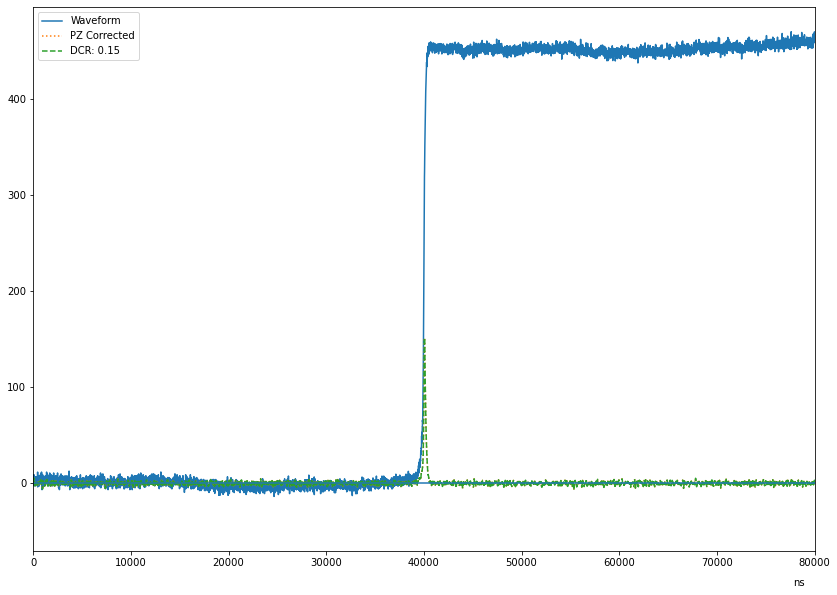

In [58]:
browser.draw_next()

In [59]:
# import pygama
pygama.__path__

['/global/cfs/cdirs/majorana/projecta/majorana/users/gothman/joule_pygama/pygama']

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-60-529036584a3d>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tail = plt.pcolormesh(XX_tail, YY_tail, tail_slope_vs_E_hist_norm, norm=LogNorm())


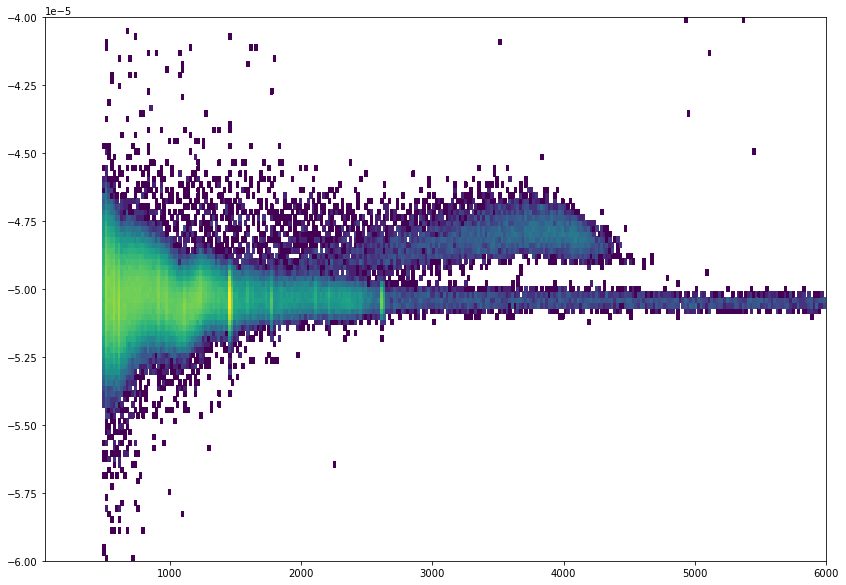

In [60]:

nb_tail = 100 #500
tail_lo, tail_hi = -0.00006,-0.00004
nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tail_slope_vs_E_hist_norm, tail_xedges, tail_yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['log_tail_fit_slope'], bins=[nb_energy, nb_tail], range=([elo, ehi], [tail_lo, tail_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tail, YY_tail = np.mgrid[elo:ehi:nb_energy*1j, tail_lo:tail_hi:nb_tail*1j]

pcm1_tail = plt.pcolormesh(XX_tail, YY_tail, tail_slope_vs_E_hist_norm, norm=LogNorm())

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-61-b1cc1d6dcecb>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tail_mean = plt.pcolormesh(XX_tail_mean, YY_tail_mean, tail_mean_vs_E_hist_norm, norm=LogNorm())


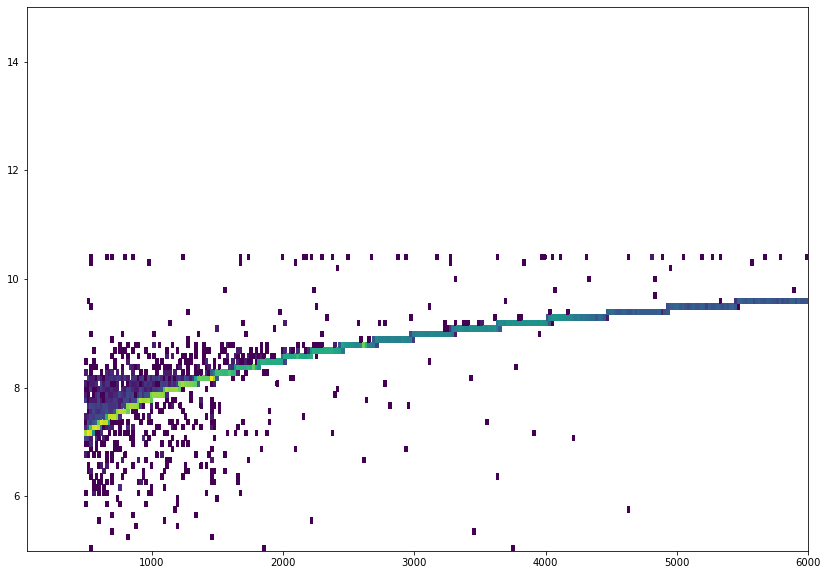

In [61]:
nb_tail_mean = 100 #500
tail_mean_lo, tail_mean_hi = 5, 15
nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tail_mean_vs_E_hist_norm, tail_xedges, tail_yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['log_tail_fit_mean'], bins=[nb_energy, nb_tail_mean], range=([elo, ehi], [tail_mean_lo, tail_mean_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tail_mean, YY_tail_mean = np.mgrid[elo:ehi:nb_energy*1j, tail_mean_lo:tail_mean_hi:nb_tail_mean*1j]

pcm1_tail_mean = plt.pcolormesh(XX_tail_mean, YY_tail_mean, tail_mean_vs_E_hist_norm, norm=LogNorm())

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-62-372bb2b73e95>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tail_sig = plt.pcolormesh(XX_tail_mean, YY_tail_mean, tail_mean_vs_E_hist_norm, norm=LogNorm())


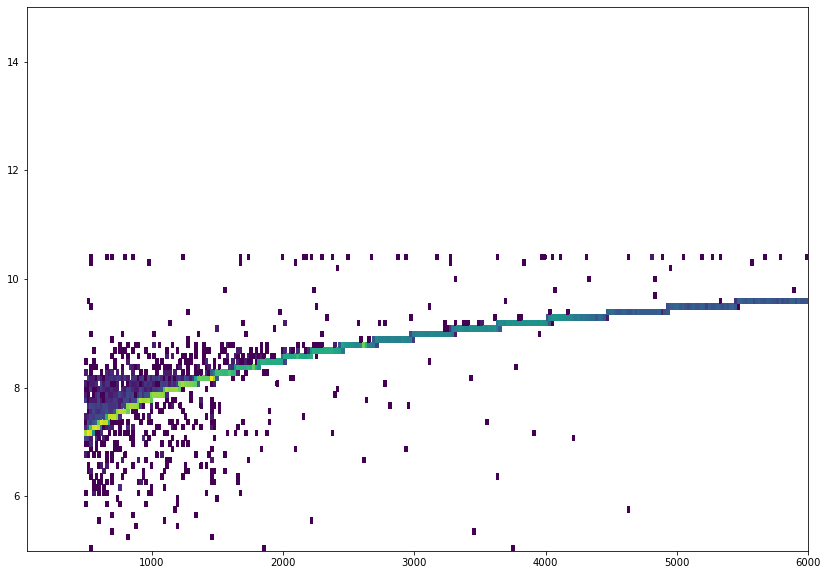

In [62]:
nb_tail_sig = 100 #500
tail_sig_lo, tail_sig_hi = 5, 15
nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tail_sig_vs_E_hist_norm, tail_sig_xedges, tail_sig_yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['lot_tail_fit_sigma'], bins=[nb_energy, nb_tail_sig], range=([elo, ehi], [tail_sig_lo, tail_sig_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tail_sig, YY_tail_sig = np.mgrid[elo:ehi:nb_energy*1j, tail_sig_lo:tail_sig_hi:nb_tail_sig*1j]

pcm1_tail_sig = plt.pcolormesh(XX_tail_mean, YY_tail_mean, tail_mean_vs_E_hist_norm, norm=LogNorm())

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-63-56ddbd74b58b>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tail_dcr = plt.pcolormesh(XX_tail_dcr, YY_tail_dcr, tail_slope_vs_DCR_hist_norm, norm=LogNorm())


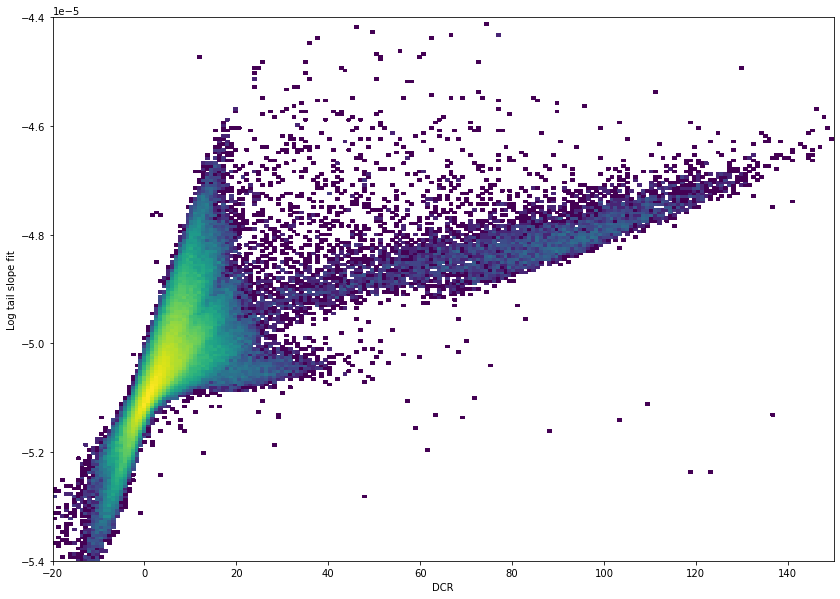

In [63]:
nb_tail = 200 #500
tail_lo, tail_hi = -0.000054,-0.000044 #-0.00006,-0.00004 #

nb_dcr = 200 #500
dlo_norm, dhi_norm = -20, 150

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tail_slope_vs_DCR_hist_norm, tail_xedges, tail_yedges = np.histogram2d(df_cut['dcr'], df_cut['log_tail_fit_slope'], bins=[nb_dcr, nb_tail], range=([dlo_norm, dhi_norm], [tail_lo, tail_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tail_dcr, YY_tail_dcr = np.mgrid[dlo_norm:dhi_norm:nb_dcr*1j, tail_lo:tail_hi:nb_tail*1j]

pcm1_tail_dcr = plt.pcolormesh(XX_tail_dcr, YY_tail_dcr, tail_slope_vs_DCR_hist_norm, norm=LogNorm())


plt.xlabel('DCR')
plt.ylabel('Log tail slope fit')
plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-64-2da9fc724e8c>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_ToE_dcr = plt.pcolormesh(XX_ToE_dcr, YY_ToE_dcr, ToE_vs_DCR_hist_norm, norm=LogNorm())


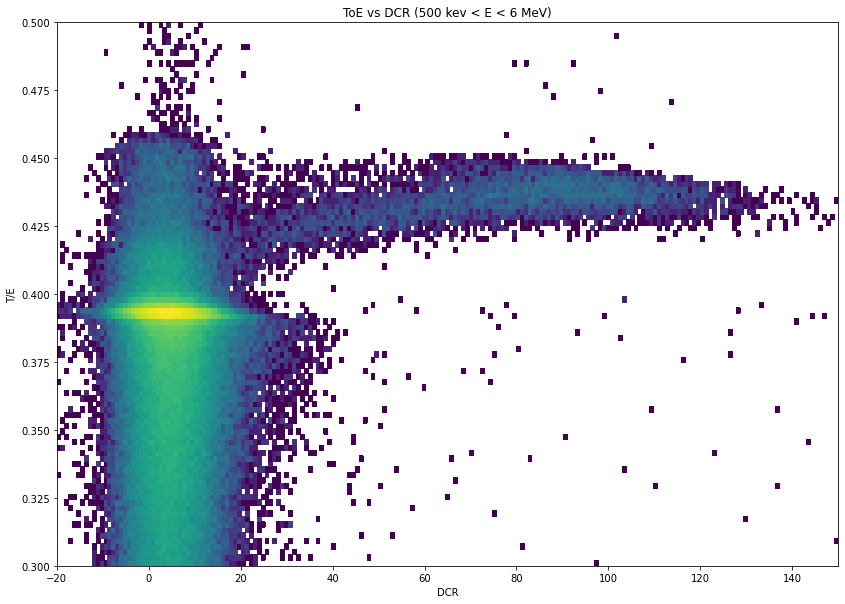

In [64]:
nb_t = 100 #500
t_lo, t_hi = 0.3, 0.5 #-0.00006,-0.00004 #

nb_dcr = 200 #500
dlo_norm, dhi_norm = -20, 150

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

ToE_vs_DCR_hist_norm, tail_xedges, tail_yedges = np.histogram2d(df_cut['dcr'], df_cut['ToE'], bins=[nb_dcr, nb_t], range=([dlo_norm, dhi_norm], [t_lo, t_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_ToE_dcr, YY_ToE_dcr = np.mgrid[dlo_norm:dhi_norm:nb_dcr*1j, t_lo:t_hi:nb_t*1j]

pcm1_ToE_dcr = plt.pcolormesh(XX_ToE_dcr, YY_ToE_dcr, ToE_vs_DCR_hist_norm, norm=LogNorm())

plt.title('ToE vs DCR (500 kev < E < 6 MeV)')
plt.xlabel('DCR')
plt.ylabel('T/E')

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-65-a75b9eb870e1>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_ToE_energy = plt.pcolormesh(XX_ToE_energy, YY_ToE_energy, ToE_vs_energy_hist_norm, norm=LogNorm())


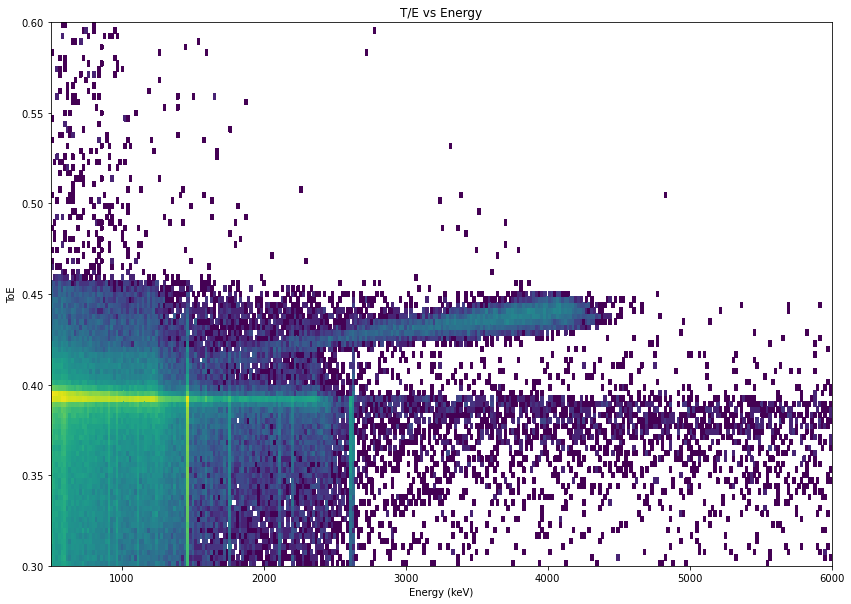

In [65]:
nb_t = 100 #500
t_lo, t_hi = 0.3, 0.6#-0.00006,-0.00004 #

nb_energy = 299 #599
elo = 500
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

ToE_vs_energy_hist_norm, tail_xedges, tail_yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['ToE'], bins=[nb_energy, nb_t], range=([elo, ehi], [t_lo, t_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_ToE_energy, YY_ToE_energy = np.mgrid[elo:ehi:nb_energy*1j, t_lo:t_hi:nb_t*1j]

pcm1_ToE_energy = plt.pcolormesh(XX_ToE_energy, YY_ToE_energy, ToE_vs_energy_hist_norm, norm=LogNorm())

plt.ylabel('ToE')
plt.xlabel('Energy (keV)')
plt.title('T/E vs Energy')

plt.show()


In [66]:
df_cut['tp_10_96'] = df_cut['tp_96'] - df_cut['tp_10']
df_cut['tp_10_50'] = df_cut['tp_50'] - df_cut['tp_10']
df_cut['tp_50_max'] = df_cut['tp_max'] - df_cut['tp_50']
df_cut['tp_10_30'] = df_cut['tp_30'] - df_cut['tp_10']
df_cut['tp_0_30'] = df_cut['tp_30'] - df_cut['tp_0']


[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-67-77e6cb8bc860>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tail_dcr = plt.pcolormesh(XX_tp_10_96_dcr, YY_tp_10_96_dcr, tp_10_96_vs_DCR_hist_norm, norm=LogNorm())


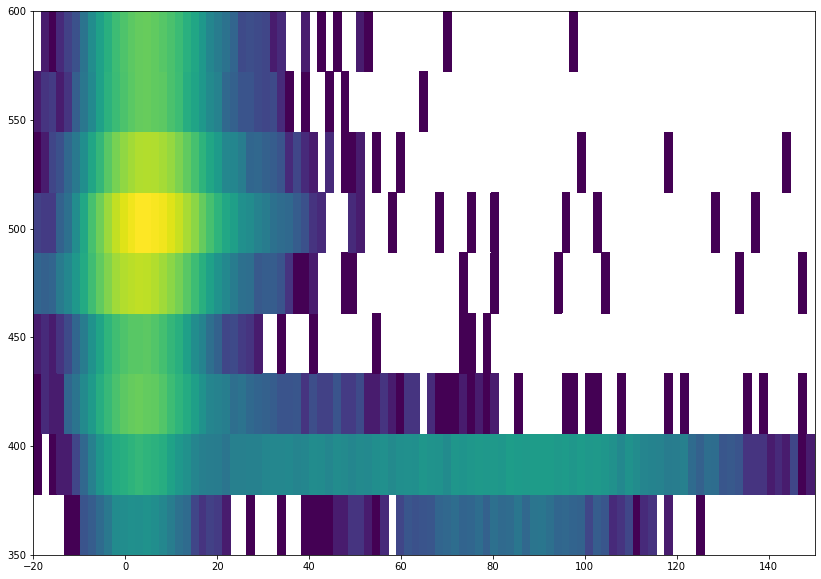

In [67]:


nb_tp_10_96 = 10 #500
tp_10_96_lo, tp_10_96_hi = 350, 600

nb_dcr = 100 #500
dlo_norm, dhi_norm = -20, 150

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tp_10_96_vs_DCR_hist_norm, tp_10_96_xedges, tp_10_96_yedges = np.histogram2d(df_cut['dcr'], df_cut['tp_10_96'], bins=[nb_dcr, nb_tp_10_96], range=([dlo_norm, dhi_norm], [tp_10_96_lo, tp_10_96_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tp_10_96_dcr, YY_tp_10_96_dcr = np.mgrid[dlo_norm:dhi_norm:nb_dcr*1j, tp_10_96_lo:tp_10_96_hi:nb_tp_10_96*1j]

pcm1_tail_dcr = plt.pcolormesh(XX_tp_10_96_dcr, YY_tp_10_96_dcr, tp_10_96_vs_DCR_hist_norm, norm=LogNorm())

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-68-25319efb53e6>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tail_dcr = plt.pcolormesh(XX_tp_10_50_dcr, YY_tp_10_50_dcr, tp_10_50_vs_DCR_hist_norm, norm=LogNorm())


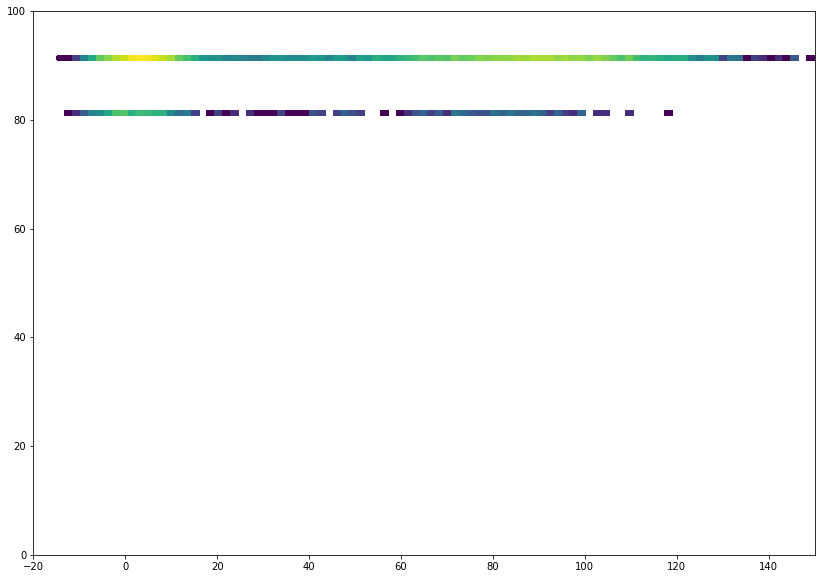

In [68]:
nb_tp_10_50 = 100 #500
tp_10_50_lo, tp_10_50_hi = 0, 100

nb_dcr = 100 #500
dlo_norm, dhi_norm = -20, 150

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tp_10_50_vs_DCR_hist_norm, tp_10_50_xedges, tp_10_50_yedges = np.histogram2d(df_cut['dcr'], df_cut['tp_10_50'], bins=[nb_dcr, nb_tp_10_50], range=([dlo_norm, dhi_norm], [tp_10_50_lo, tp_10_50_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tp_10_50_dcr, YY_tp_10_50_dcr = np.mgrid[dlo_norm:dhi_norm:nb_dcr*1j, tp_10_50_lo:tp_10_50_hi:nb_tp_10_50*1j]

pcm1_tail_dcr = plt.pcolormesh(XX_tp_10_50_dcr, YY_tp_10_50_dcr, tp_10_50_vs_DCR_hist_norm, norm=LogNorm())

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-69-257ee3a6e843>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tp_10_30_dcr= plt.pcolormesh(XX_tp_10_30_dcr, YY_tp_10_30_dcr, tp_10_30_vs_DCR_hist_norm, norm=LogNorm())


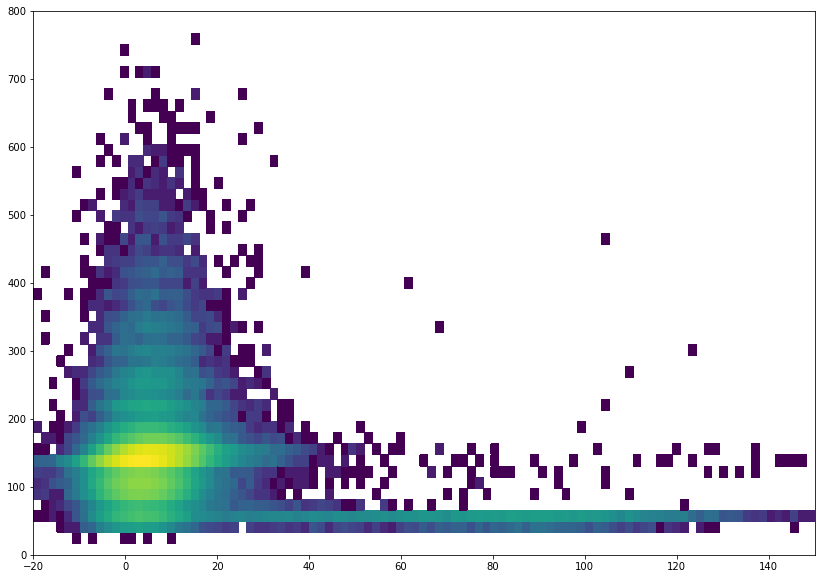

In [69]:
nb_tp_10_30 = 50 #500
tp_10_30_lo, tp_10_30_hi = 0, 800

nb_dcr = 100 #500
dlo_norm, dhi_norm = -20, 150

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tp_10_30_vs_DCR_hist_norm, tp_10_30_xedges, tp_10_30_yedges = np.histogram2d(df_cut['dcr'], df_cut['tp_10_30'], bins=[nb_dcr, nb_tp_10_30], range=([dlo_norm, dhi_norm], [tp_10_30_lo, tp_10_30_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tp_10_30_dcr, YY_tp_10_30_dcr = np.mgrid[dlo_norm:dhi_norm:nb_dcr*1j, tp_10_30_lo:tp_10_30_hi:nb_tp_10_30*1j]

pcm1_tp_10_30_dcr= plt.pcolormesh(XX_tp_10_30_dcr, YY_tp_10_30_dcr, tp_10_30_vs_DCR_hist_norm, norm=LogNorm())

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-70-744f7319c18f>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tp_10_50_dcr = plt.pcolormesh(XX_tp_50_max_dcr, YY_tp_50_max_dcr, tp_50_max_vs_DCR_hist_norm, norm=LogNorm())


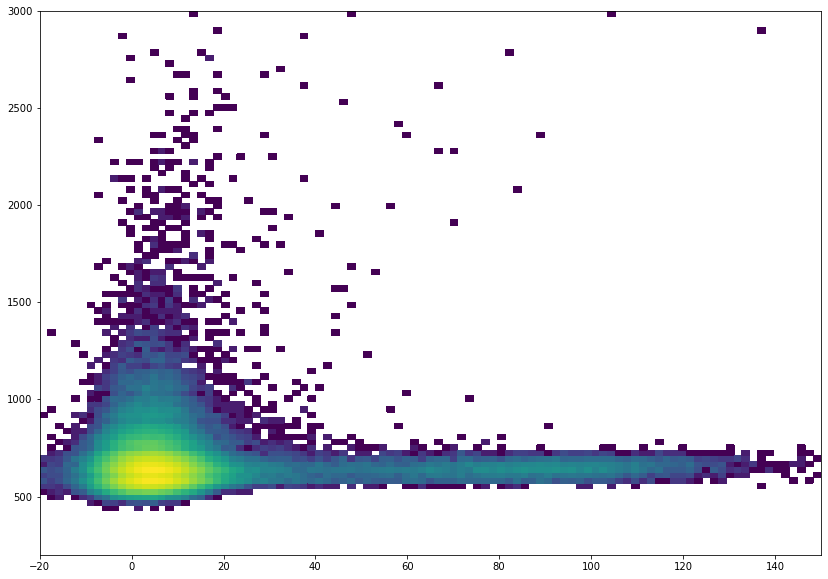

In [70]:
nb_tp_50_max = 100 #500
tp_50_max_lo, tp_50_max_hi =200, 3000

nb_dcr = 100 #500
dlo_norm, dhi_norm = -20, 150

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tp_50_max_vs_DCR_hist_norm, tp_50_max_xedges, tp_50_max_yedges = np.histogram2d(df_cut['dcr'], df_cut['tp_50_max'], bins=[nb_dcr, nb_tp_50_max], range=([dlo_norm, dhi_norm], [tp_50_max_lo, tp_50_max_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tp_50_max_dcr, YY_tp_50_max_dcr = np.mgrid[dlo_norm:dhi_norm:nb_dcr*1j, tp_50_max_lo:tp_50_max_hi:nb_tp_50_max*1j]

pcm1_tp_10_50_dcr = plt.pcolormesh(XX_tp_50_max_dcr, YY_tp_50_max_dcr, tp_50_max_vs_DCR_hist_norm, norm=LogNorm())



plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-71-92e8e0c98ecd>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tp_10_96_dcr = plt.pcolormesh(XX_tp_10_96_energy, YY_tp_10_96_energy, tp_10_96_vs_energy_hist_norm, norm=LogNorm())


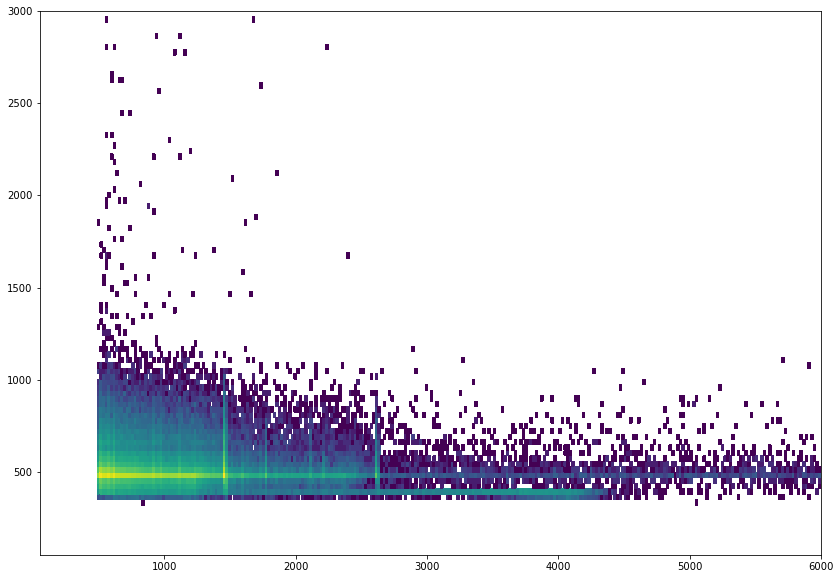

In [71]:
nb_tp_10_96 = 100 #500
tp_10_96_lo, tp_10_96_hi = 50, 3000

nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tp_10_96_vs_energy_hist_norm, tp_10_96_xedges, tp_10_96_yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['tp_10_96'], bins=[nb_energy, nb_tp_10_96], range=([elo, ehi], [tp_10_96_lo, tp_10_96_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tp_10_96_energy, YY_tp_10_96_energy = np.mgrid[elo:ehi:nb_energy*1j, tp_10_96_lo:tp_10_96_hi:nb_tp_10_96*1j]

pcm1_tp_10_96_dcr = plt.pcolormesh(XX_tp_10_96_energy, YY_tp_10_96_energy, tp_10_96_vs_energy_hist_norm, norm=LogNorm())

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-72-cb6a8d532ea6>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tp_10_50_dcr = plt.pcolormesh(XX_tp_10_50_energy, YY_tp_10_50_energy, tp_10_50_vs_energy_hist_norm, norm=LogNorm())


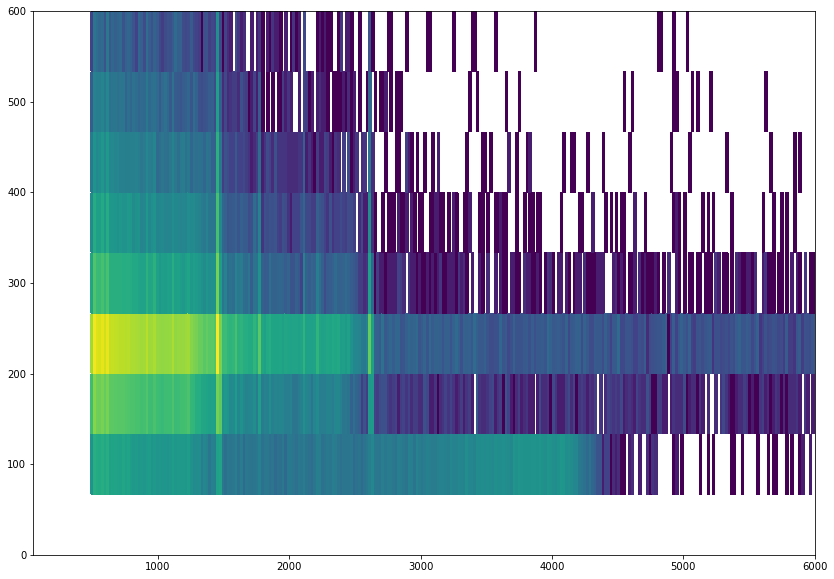

In [72]:
nb_tp_10_50 = 10 #500
tp_10_50_lo, tp_10_50_hi =0, 600

nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tp_10_50_vs_energy_hist_norm, tp_10_50_xedges, tp_10_96_yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['tp_10_50'], bins=[nb_energy, nb_tp_10_50], range=([elo, ehi], [tp_10_50_lo, tp_10_50_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tp_10_50_energy, YY_tp_10_50_energy = np.mgrid[elo:ehi:nb_energy*1j, tp_10_50_lo:tp_10_50_hi:nb_tp_10_50*1j]

pcm1_tp_10_50_dcr = plt.pcolormesh(XX_tp_10_50_energy, YY_tp_10_50_energy, tp_10_50_vs_energy_hist_norm, norm=LogNorm())

plt.show()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-73-cfeaf58f5acf>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1_tail_dcr = plt.pcolormesh(XX_tp_10_96_dcr, YY_tp_10_96_dcr, tp_10_96_vs_DCR_hist_norm, norm=LogNorm())


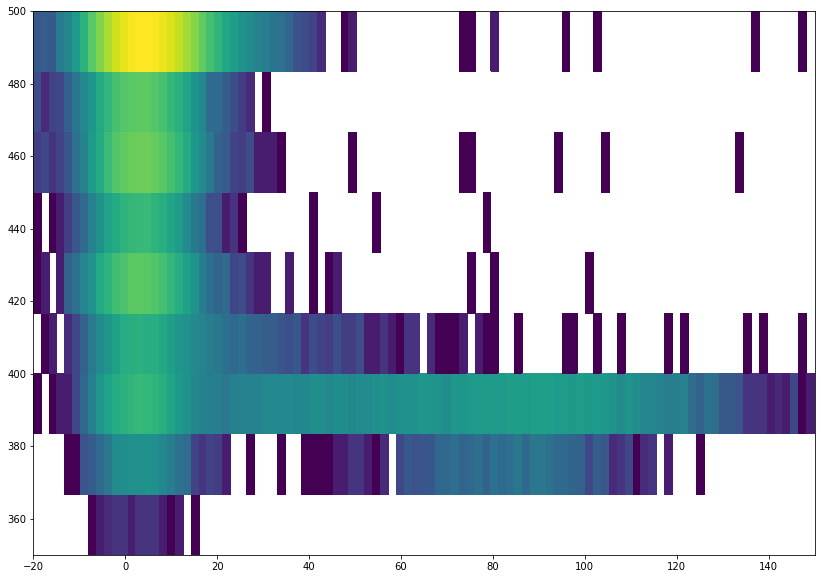

In [73]:
nb_tp_10_96 = 10 #500
tp_10_96_lo, tp_10_96_hi = 350, 500

nb_dcr = 100 #500
dlo_norm, dhi_norm = -20, 150

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

tp_10_96_vs_DCR_hist_norm, tp_10_96_xedges, tp_10_96_yedges = np.histogram2d(df_cut['dcr'], df_cut['tp_10_96'], bins=[nb_dcr, nb_tp_10_96], range=([dlo_norm, dhi_norm], [tp_10_96_lo, tp_10_96_hi]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX_tp_10_96_dcr, YY_tp_10_96_dcr = np.mgrid[dlo_norm:dhi_norm:nb_dcr*1j, tp_10_96_lo:tp_10_96_hi:nb_tp_10_96*1j]

pcm1_tail_dcr = plt.pcolormesh(XX_tp_10_96_dcr, YY_tp_10_96_dcr, tp_10_96_vs_DCR_hist_norm, norm=LogNorm())

plt.show()